In [2]:
# General setup
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import site

import time
# from numba import jit

from astropy.cosmology import Planck15


import pickle
import random 
import math
import os
from scipy.stats import chi2

import h5py 

# Step 1: Read in all of the necessary files (.pkl maps, light cone, dark cone)

In [3]:
def read_lightcone(redshift_SFH, realization, next_z):
    
    # lower edge redshift bound. change this if you want a different partition
    z = redshift_SFH
    
    # path to data
    dataPath = f'/Users/slkumar/Downloads/RunBubbles/{realization}'
    partition = 'part_z{:.2f}_z{:.2f}'.format(z, next_z)
    # lightcone.dat contains the galaxy properties of everything in the partition 
    # we will first load it to grab the header information ... 
    with open('{}/{}/lightcone.dat'.format(dataPath, partition), 'r') as dat:
        lines   = dat.readlines()
        header  = [ line.strip().split(" ")[2] for line in lines if line[0] == "#"]
    
    # read it as a pandas csv file ... 
    galaxies = pd.read_csv('{}/{}/lightcone.dat'.format(dataPath, partition),
                           comment='#', delim_whitespace=True,
                        names = header, header=None)
    
    # we only have star formation histories (SFHs) for centrals (gal_type == 0) so only grab those 
    centrals = galaxies[galaxies['gal_type'] == 0].reset_index(drop=True)
    # the midpoints of the metallicity bins
    Zbins = np.array([-2.37083, -2.1125, -1.85417, -1.59583, -1.3375, -1.07917, 
         -0.820833, -0.5625, -0.304167, -0.0458333, 0.2125, 0.470833])
    # loading the bpass table to grab the age bins ... 
    table = np.loadtxt('/Users/slkumar/Downloads/nion_bpass.txt', comments='#')
    tbins = 10**table[:, 0]
    # append 0 yr to the front 
    #tbins = np.hstack([1, tbins])
    # the SFHs are in a non-standard format so we need to load it in chunks and read through it that way 
    # each chunk is 198 lines so a pandas reader works well here 
    reader = pd.read_csv('{}/{}/sfhist.dat'.format(dataPath, partition), 
                         iterator=True, comment='#', chunksize=198, delim_whitespace=True,
                        names = [0,1,2,3,4,5,6,7,8,9,10,11], header=None)
    
    # because the pandas reader does not know how long the actual file is, we have to 
    # hard instantiate and track the central galaxy id to index into the centrals dataframe 
    cen_id = -1 
    
    for df in reader:
        # iterate up the central index 
        cen_id = cen_id + 1
    
        # galaxy parameters (two items) from the SFH
        galparam = df.to_numpy()[0, 0:2]
        # the actual SFH which has shape 197 x 12 
        # there are 12 metallicity bins, and 197 time bins (in semi-log space lookback time) 
        sfhZt = df.to_numpy()[1:,:] 
        # grab the galaxy's redshift from the central dataframe 
        gal_z = centrals.iloc[cen_id]['redshift']
        
        if cen_id >= 0: 
            break # comment this out when not working with a single SFH 
    return centrals, galaxies, sfhZt, tbins, reader

def create_bins(sfhZt, tbins): 
    #getting the age bins that correspond to the row of the grid from the sfh 
    bins_30 = []
    bins_10 = []
    bin_index_30 = []
    bin_index_10 = []

    #looping through the length of the SFH bc that is the same length as the time bins
    for i in range(sfhZt.shape[0]):
        
        #only choosing age bins that are below 30 Myr
        if tbins[i] < 30*10**6: 
            bins_30.append(tbins[i])
            bin_index_30.append(i)
        
        #choosing age bins that are below 10Myr
        if tbins[i] < 10*10**6: 
            bins_10.append(tbins[i])
            bin_index_10.append(i)
            
    #bins = (np.array(bins).flatten()) / 1e6
    return bin_index_10, bin_index_30, bins_10
    
def read_files(z, realization, nextz): 
    # lower edge redshift bound. change this if you want a different partition
    #z = 7
    
    # path to data
    dataPath = f'/Users/slkumar/Downloads/RunBubbles/{realization}'
    partition = 'part_z{:.2f}_z{:.2f}'.format(z, nextz)
    
    # the SFHs are in a non-standard format so we need to load it in chunks and read through it that way 
    # each chunk is 198 lines so a pandas reader works well here 
    reader = pd.read_csv('{}/{}/sfhist.dat'.format(dataPath, partition), 
                         iterator=True, comment='#', chunksize=198, delim_whitespace=True,
                        names = [0,1,2,3,4,5,6,7,8,9,10,11], header=None)
    with open('{}/{}/lightcone.dat'.format(dataPath, partition), 'r') as dat:
        lines   = dat.readlines()
        header  = [ line.strip().split(" ")[2] for line in lines if line[0] == "#"]
    # read it as a pandas csv file ... 
    galaxies = pd.read_csv('{}/{}/lightcone.dat'.format(dataPath, partition),
                           comment='#', delim_whitespace=True,
                        names = header, header=None)
    
    # we only have star formation histories (SFHs) for centrals (gal_type == 0) so only grab those 
    centrals = galaxies[galaxies['gal_type'] == 0].reset_index(drop=True)
    return reader, galaxies, centrals 

def read_data_dc(x, special=False):
    with open(x, 'r') as dat:
        first_line = dat.readline()
        if special == False:
            header  = first_line[1:].split(' ')
        if special == 'wide':
            header = '#Scale ID PID Mass Vmax Mass_peak Vmax_peak Rvir X Y Z VX VY VZ Ra Dec Z(cosmo) Z(los) Cumulative_ND(VMpeak) Tree_RootID Depthfirst_ID Last_Progenitor_ID Halfmass_Scale Acc_Rate_Tdyn Acc_Rate_2Tdyn Vmax@Mpeak'[1:].split(' ')
        if special == 'deep':
            header = '#Scale ID PID Mass Vmax Mass_peak Vmax_peak Rvir X Y Z VX VY VZ Ra Dec Z(cosmo) Z(los) Cumulative_ND(VMpeak) Tree_RootID Depthfirst_ID Last_Progenitor_ID Halfmass_Scale Acc_Rate_Tdyn Acc_Rate_2Tdyn Vmax@Mpeak'[1:].split(' ')
    return pd.read_table(x, comment="#", delim_whitespace=True, names=header)

def read_data_Roman(x):
    with open(x, 'r') as dat:
        lines   = dat.readlines()
        header  = [ line.strip().split(" ")[2] for line in lines if line[0] == "#"]
        temp    = pd.read_table(x, comment="#", delim_whitespace=True, names=header)
        temp['ra2'] = [temp['ra'][_] if temp['ra'][_]<180. else temp['ra'][_] - 360 for _ in range(len(temp))]
    return temp

def pre_processing(lightcone, darkcone, new_coord):
    halo_X = pd.Series(list(darkcone.X),index=darkcone.ID).to_dict()
    halo_Y = pd.Series(list(darkcone.Y),index=darkcone.ID).to_dict()
    halo_Z = pd.Series(list(darkcone.Z),index=darkcone.ID).to_dict()

    # in cMpc / h
    lightcone['X'] = lightcone['halo_id_nbody'].map(halo_X)
    lightcone['Y'] = lightcone['halo_id_nbody'].map(halo_Y)
    lightcone['Z'] = lightcone['halo_id_nbody'].map(halo_Z)

    # convert from cMpc / h to Mpc (pMpc) by ..
    # cMpc = cMpc / h * h / 0.6774
    # pMpc = cMpc / (1 + z)
    # pMpc = (cMpc / 0.6774) / (1 + z)
    lightcone['X'] = (lightcone['X'] / 0.6774) / (1 + lightcone.redshift)
    lightcone['Y'] = (lightcone['Y'] / 0.6774) / (1 + lightcone.redshift)
    lightcone['Z'] = (lightcone['Z'] / 0.6774) / (1 + lightcone.redshift)

    # fix the sat positions by converting from spherical coordinates to cartesian 
    # x = r*sin(theta)*cos(phi)
    # y = r*sin(theta)*sin(phi)
    # z = r*cos(theta)
    # r = r_fric (kpc), theta = theta, phi = phi
    # local coordinates (centered around central (0, 0, 0)) to global (centered around central based on halo position)
    # note RA maps to inv. Y, Dec maps to Z, redshift maps to X 
    r_fric = pd.Series(list(new_coord.r_fric / 1000),index=new_coord.halo_id_nbody).to_dict() 
    theta = pd.Series(list(new_coord.theta),index=new_coord.halo_id_nbody).to_dict()
    phi = pd.Series(list(new_coord.phi),index=new_coord.halo_id_nbody).to_dict()

    lightcone['r_fric'] = lightcone['halo_id_nbody'].map(r_fric)
    lightcone['theta'] = lightcone['halo_id_nbody'].map(theta)
    lightcone['phi'] = lightcone['halo_id_nbody'].map(phi)

    lightcone.X += lightcone.r_fric*np.sin(lightcone.theta*np.pi/180)*np.cos(lightcone.phi*np.pi/180) 
    lightcone.Y += lightcone.r_fric*np.sin(lightcone.theta*np.pi/180)*np.sin(lightcone.phi*np.pi/180) 
    lightcone.Z += lightcone.r_fric*np.cos(lightcone.theta*np.pi/180) 

    #     #  Calculate stellar mass based on mean age and SFR
    #     #  Note, ages in Gyr, mstardot in Msun/yr, and masses in units of 1e10 Msun
    #     lightcone["mstarcalc"] = lightcone["mstardot"] * lightcone["meanage"] / 10.  #  In 1e10 Msun
    #     lightcone["mstaravgcalc"] = lightcone["sfr_ave"] * lightcone["meanage"] / 10.  #  In 1e10 Msun
    
    #     # Let's get a bunch of useful stuff for predicting LyA luminosity in a plausible way.
    
    #     # First peculiar velocity, in km/s.
    #     lightcone["vpec"] = 2.998e5 * (lightcone["redshift"] - lightcone["z_nopec"]) / (1 + lightcone["z_nopec"])
    #     lightcone["lnucont"] = lightcone["mstardot"] / 1.4e-28 
    
    #     lightcone["nionhi"] = lightcone["lnucont"] * 10.**25.8 * fe
    #     lightcone["nionlo"] = lightcone["lnucont"] * 10.**25.3 * fe
    
    return lightcone


# Step 2: Find the SFR and select galaxies based on your criteria

`get_SFR` = function that sorts through each redshift bin, sums up the star formation history line, and divides by 10Myr to get the SFR
The star formation history is a grid with metallicity and stellar age. Adding the row gets the star formation history and dividing by 10 Myr gets the star formation rate. This function returns the star formation rate for a given redshift slice and the indices of the galaxies within that redshift slice

`select_subpop` = selecting galaxies that are within redshift slice that are closest to the ionization map we are looking at 

`fesc_index` = finding galaxies from `get_SFR` that have a luminosity and SFR above some threshold, also applying the random f_esc values 

`finding_index` = finding where austen's data frame (returned from select_subpop) is the same as mine (returned from fesc_index)

In [4]:
def get_SFR(redshift_SFH, redshift_min, redshift_max, realization, nextz): 
    sfr = []
    cen_id = -1
    reader, galaxies, centrals = read_files(redshift_SFH, realization, nextz)
    #index list of galaxies from the centrals data frame whose z < 7.08
    galaxy_index = []
    for df in reader:
        #grabbing star formation history 
        sfhZt = df.to_numpy()[1:,:] 
    
        
        rows_10 = []
        cen_id = cen_id + 1
        gal_z = centrals['redshift'][cen_id]
        
        if gal_z <= redshift_max and gal_z >= redshift_min:
            if cen_id%10000 == 0: 
                print(cen_id)
            #creating a while loop to get the sfr for 10 Myr
            i = 0
            galaxy_index.append(cen_id)
            while i != len(bin_index_10):
                row = np.sum(sfhZt[bin_index_10[i]])
                rows_10.append(row)
                    
                i += 1
            
            sfr.append(sum(rows_10) / (10*10**6))
        else: 
            continue
    return sfr, galaxy_index

def select_subpop(full_cone, res, redshift): 
    envelope = 0.15
    #selecting galaxies that have redshift close to the redshift of the ionization map 
    select_z = full_cone.loc[np.abs(full_cone.redshift - redshift) < envelope].reset_index(drop=True)
    
    #res['x0'] represents the redshift/Mpc
    subpop = select_z[abs(select_z.X - res['x0']) < 1].reset_index(drop=True)

    return subpop

def fesc_index(sfr, galaxy_index, luminosity_threshold, sfr_threshold):
    # SFR = array of SFR values 
    #galaxy_index = array of index of galaxies to be used in function 
    #reading table to get the escape fraction 
    filepath = r'/Users/slkumar/Downloads/papertable.txt'
    f_escape = pd.read_csv(filepath, skiprows = 41, sep='\s+', header = None, na_filter=False, usecols = [5], nrows = 40, dtype = float)
    escape_frac = np.array(f_escape[5])
    lum_lyA = np.array(sfr)*10**42
    
    #calculating the luminosity that escapes from the ionized bubble, randomly chooses escape fraction 
    lum_lyA_fesc = [] 
    for i in range(len(lum_lyA)): 
        #getting random escape fraction and multiplying that by lyA luminosity 
        rand_esc = random.choice(escape_frac)
        lum_lyA_current = rand_esc * lum_lyA[i]
        lum_lyA_fesc.append(lum_lyA_current)
    
    #finding where the escape fraction luminosity is greater than 10**43 and SFR > 10
    f_esc = np.array(lum_lyA_fesc)[np.where((np.array(lum_lyA_fesc) >= luminosity_threshold) & (np.array(sfr) >= sfr_threshold))[0]]
    
    #getting the index that corresponds to the escape fractions, mask for the galaxy_index 
    index_fesc = np.where((np.array(lum_lyA_fesc) >= luminosity_threshold) & (np.array(sfr) >= sfr_threshold))[0]
    
    #this index can be used for the centrals df 
    gal_fesc = np.array(galaxy_index)[index_fesc]

    #lya 
    lya = np.array(lum_lyA)[index_fesc]
    
    return gal_fesc, f_esc, lya
    
def finding_index(df, index_list): 
    #finding where the indexes are the same between my data frame and austen's data frame 
    #df = austen's data frame
    #index_list = my list of ids that come from my data frame 
    #returns list of indexes that correspond to the same halo_id_nbody 
    index = []
    j = 0
    for i in range(len(df['halo_id_nbody'])): 
        for j in range(len(index_list)): 
            current_id = df['halo_id_nbody'][i]
            if current_id == index_list[j]: 
                index.append(i)
            else: 
                continue
                
    return index
    

<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/174876651.py:48: SyntaxWarning: invalid escape sequence '\s'
  f_escape = pd.read_csv(filepath, skiprows = 41, sep='\s+', header = None, na_filter=False, usecols = [5], nrows = 40, dtype = float)


# Step 3: Generate the Maps & DataFrames/CSV Files

`create_df_noradius` = creating a data frame that does not include radius values. This returned data frame only includes redshift, galaxy index, luminosity, fesc luminosity. I do this because we end up changing the f_esc threshold when doing transmission calculations, it's easier to have a clean data frame 

`find_galaxies_in_map` = finding where the galaxies we found (returned from finding_index) are NOT within the 1pMpc rind. If it is, we throw it out and it is removed from the data frame 

In [5]:
def create_df_noradius(halo_id_nbody): 
    #run only once!!
    column_names = ['halo_id_nbody', 'gal coord y (pMpc)', 'gal coord z (pMpc)']   
    galaxy_df = pd.DataFrame(columns=[column_names])
    galaxy_df['halo_id_nbody'] = halo_id_nbody
    galaxy_df = galaxy_df.reset_index()
    return galaxy_df

def find_galaxies_in_map(galaxy_df, df_to_read, index_to_use, realization, z, hdf5path): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(5.50, 9.85, realization, hdf5path)
    mpc_per_arcmin = Planck15.kpc_proper_per_arcmin(z).value * 1/1000 
    for current_index in range(len(index_to_use)):
        gal_coords = [df_to_read.Y[index_to_use[current_index]], df_to_read.Z[index_to_use[current_index]]]
        #print("og coords", gal_coords)
        #print("current index:", index_to_use[current_index], current_index)
        #getting the coordinate in Z-Y space
        """In order to find where the index is that corresponds to the galaxy coordinates, need to find closest value corresponding to 
        the ionization map. To do this we need to subtract the coordinate array from the current coordinate. Whichever one is closest to 0
        is the coordinate that is closest to the galaxy coordinate. Also need to round because they won't always be 0. 
        """
        y0vec = y0vec_arcmin * mpc_per_arcmin
        z0vec = z0vec_arcmin * mpc_per_arcmin
        
        differencey = abs(y0vec - gal_coords[0])
        differencez = abs(z0vec - gal_coords[1])
        
        possible_yindex = np.where(differencey == min(differencey))[0]
        possible_zindex = np.where(differencez == min(differencez))[0]
        
        #find where the lowest difference is and what index it is, zip truncates two lists together and sorts them, returns index 
        y_index = sorted(zip(possible_yindex, differencey))[0][0]
        z_index = sorted(zip(possible_zindex, differencez))[0][0]
        
        #cutting off rind of 1 pMpc
        rindy_min = np.where(y0vec <= min(y0vec) + 1)[0][-1]
        rindy_max = np.where(y0vec >= max(y0vec) - 1)[0][0]
        rindz_min = np.where(z0vec <= min(z0vec) + 1)[0][-1]
        rindz_max = np.where(z0vec >= max(z0vec) - 1)[0][0]
        
        #filtering out galaxies that are within that 1pMpc rind, removing them from the data frame
        if y_index <= rindy_min or y_index >= rindy_max or z_index <= rindz_min or z_index >= rindz_max: 
            removed_row = np.where(galaxy_df['index'] == index_to_use[current_index])[0][0]
            print("Need to remove",removed_row)
            print(y_index, z_index)
            print(rindy_min, rindy_max, rindz_min, rindz_max)
            galaxy_df = galaxy_df.drop(removed_row)
            galaxy_df = galaxy_df.reset_index(drop = True)
            continue
        else:
            #map coordinates 
            starting_y = y0vec[y_index]
            starting_z = z0vec[z_index]
            print("passed:", y_index, z_index)
            index_to_add = np.where(galaxy_df['index'] == index_to_use[current_index])[0][0]
            galaxy_df.loc[index_to_add, 'gal coord y (pMpc)'] = starting_y
            galaxy_df.loc[index_to_add, 'gal coord z (pMpc)'] = starting_z
            #print("gal coords:", starting_y, starting_z)
    return galaxy_df

# Step 3.5: Plot Ionization Maps

In [6]:
def size_func_exp_mstar(x, x1=6, y1=2):
    return y1*np.exp((x-x1))-1.5
    
def new_ionization_map(z, radius_data, maps, extent, realization, hdf5path): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(5.50, 9.85, realization, hdf5path)
    map_key = 'BPASS_Bin_Rec'
    map = (maps['z_{:.3f}'.format(z)][map_key][:])
    #df = pd.read_csv(radius_data_path, header = 0)
    df = radius_data
    mpc_per_arcmin = Planck15.kpc_proper_per_arcmin(z).value * 1/1000 
    min_z = z - 0.0125
    max_z = z + 0.0125    
    
    fig, ax = plt.subplots(figsize=(12,12))
    plt.title(f"z = {z} {realization} Map (z = {np.round(min_z, 4)}-{np.round(max_z, 4)})")
    
    ct = plt.imshow(map.T, origin='lower', 
                    extent=extent*mpc_per_arcmin, cmap='gist_yarg', vmax=1, vmin=0)
    
    sc = plt.scatter(df['gal coord y (pMpc)'], df['gal coord z (pMpc)'], cmap='magma_r', vmin=26, vmax=29,  c=df.NIRCam_F200W_dust, \
                    s=size_func_exp_mstar(np.log10(1e10*df.mstar)))
    
    levs = (np.array([ 0.2, 0.5, 0.8 ]))
    
    ax.contour(y0vec_arcmin*mpc_per_arcmin, y0vec_arcmin*mpc_per_arcmin, \
           map.T, [levs[0]], colors=['#DDaaa0'])
    ax.contour(y0vec_arcmin*mpc_per_arcmin, y0vec_arcmin*mpc_per_arcmin, \
               map.T, [levs[1]], colors=['#DDaaa0'], linestyles=['--'])
    ax.contour(y0vec_arcmin*mpc_per_arcmin, y0vec_arcmin*mpc_per_arcmin, \
               map.T, [levs[2]], colors=['#DDaaa0'], linestyles=[':'])
    
    # # # # plot aesthetics # # # # 
    ax.tick_params(axis='both', which='major', labelsize=14, color='white',
                width = 2, length = 9, direction = 'in')
    ax.tick_params(axis='both', which='minor', labelsize=14, color='white',
                width = 1, length = 4.5, direction = 'in')
    ax.set_xticks(np.arange(-20, 20, 2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.set_yticks(np.arange(-20, 20, 2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    
    # # # top axis # # # 
    secx = ax.secondary_xaxis('top', functions=(lambda x: -1 * x * mpc_per_arcmin**-1, 
                                                lambda x: -1 * x * mpc_per_arcmin**-1))
    secx.tick_params(axis='both', which='major', labelsize=14, color='white',
                    width = 2, length = 9, direction = 'in')
    secx.tick_params(axis='both', which='minor', labelsize=14, color='white',
                    width = 1, length = 4.5, direction = 'in')
    secx.set_xticks(np.arange(-40, 50, 10))
    secx.xaxis.set_minor_locator(MultipleLocator(2))
    secx.set_xlabel('Right Ascension (arcmin)', fontsize=14)
     
    # # # right axis # # # 
    secy = ax.secondary_yaxis('right', functions=(lambda x: x *mpc_per_arcmin**-1, 
                                                  lambda x: x * mpc_per_arcmin**-1))
    secy.tick_params(axis='both', which='major', labelsize=14, color='white',
                    width = 2, length = 9, direction = 'in')
    secy.tick_params(axis='both', which='minor', labelsize=14, color='white',
                    width = 1, length = 4.5, direction = 'in')
    secy.set_yticks(np.arange(-40, 50, 10))
    secy.yaxis.set_minor_locator(MultipleLocator(2))
    secy.set_ylabel('Declination (arcmin)', fontsize=14)
    
    plt.xlim(extent[0] * mpc_per_arcmin , extent[1] * mpc_per_arcmin)
    plt.ylim(extent[2] * mpc_per_arcmin , extent[3] * mpc_per_arcmin)
    plt.xlabel("Y (pMpc)", fontsize=14)
    plt.ylabel("Z (pMpc)",fontsize=14)
     # # scatter colorbar # # #
    
    cax = fig.add_axes([0.16, 0.18, 0.087, 0.01])
    cb = fig.colorbar(sc, cax=cax, orientation='horizontal', ticks=[26, 29, 32])
    #cb = fig.colorbar(sc, cax=cax, orientation='horizontal', ticks=[9.18, 9.20, 9.22])
    cb.outline.set_edgecolor('white')
    cax.set_xlabel('UV mag', c='white')
    cax.xaxis.label.set_color('white')
    cax.xaxis.set_label_position('top') 
    cax.tick_params(axis='x', colors='white')
    cax.xaxis.tick_top()
    #cax.set_xlim(26, 32)

    # scalebar # # #
    scalebar = AnchoredSizeBar(ax.transData, 10*mpc_per_arcmin, '10 arcmin', 'lower left',\
                              pad=2, size_vertical=0.5*1*mpc_per_arcmin, color='white', frameon=False, sep=5)
    ax.add_artist(scalebar)
    
    # # # heatmap colorbar # # # 
    hax = fig.add_axes([0.97, 0.12, 0.03, 0.76])
    ch = fig.colorbar(ct, cax=hax)
    ch.set_label(r'$ f_{\rm esc, min}$', fontsize=14)
    hax.plot([0, 1], [levs[2], levs[2]], '#DDaaa0', lw=2, ls=':')
    hax.plot([0, 1], [levs[1], levs[1]], '#DDaaa0', lw=2, ls='--')
    hax.plot([0, 1], [levs[0], levs[0]], '#DDaaa0', lw=2, ls='-')
    plt.show()
    return fig


# Step 4: Calculate the Radius and Transmission

In [65]:
def read_hdf5(minz, maxz, realization, path): 
    fname = f'sam_bubble_maps.{realization}.5.500_z_9.850.h5'
    #out_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles' 
    out_path = path
    maps = h5py.File('{}/{}'.format(out_path, fname), 'r')
    
    envelope = maps['Header'].attrs['z_env']
    nstep = maps['Header'].attrs['n_step']
    redshift = maps['Header'].attrs['redshifts']
    
    y0vec_arcmin = maps['Header'].attrs['y0vec_arcmin']
    dy_arcmin = y0vec_arcmin[1] - y0vec_arcmin[0]
    z0vec_arcmin = maps['Header'].attrs['z0vec_arcmin']
    dz_arcmin = z0vec_arcmin[1] - z0vec_arcmin[0]

    extent=np.array([y0vec_arcmin[0] - dy_arcmin / 2, 
                 y0vec_arcmin[-1] + dy_arcmin / 2, 
                 z0vec_arcmin[0] - dz_arcmin / 2, 
                 z0vec_arcmin[-1] - dz_arcmin / 2])

    return y0vec_arcmin, z0vec_arcmin, extent, envelope, maps

def calculate_radius_methodBC(radius_df, z, realization, threshold, path, minz): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(minz, 9.85, realization, path)
    map_key = 'BPASS_Bin_Rec'
    map = (maps['z_{:.3f}'.format(float(z))][map_key][:])
    mpc_per_arcmin = Planck15.kpc_proper_per_arcmin(z).value * 1/1000 
    
    for current_index in range(len(radius_df)):
        # gal_coords = [float(radius_df['gal coord y (pMpc)'].iloc[current_index]), \
        #               float(radius_df['gal coord z (pMpc)'].iloc[current_index])] 
        ygal = float(radius_df['gal coord y (pMpc)'].iloc[current_index])
        zgal = float(radius_df['gal coord z (pMpc)'].iloc[current_index])
        #print("current index:", index_to_use[current_index], current_index)
        #getting the coordinate in Z-Y space
        """In order to find where the index is that corresponds to the galaxy coordinates, need to find closest value corresponding to 
        the ionization map. To do this we need to subtract the coordinate array from the current coordinate. Whichever one is closest to 0
        is the coordinate that is closest to the galaxy coordinate. Also need to round because they won't always be 0. 
        """
        y0vec = y0vec_arcmin * mpc_per_arcmin
        z0vec = z0vec_arcmin * mpc_per_arcmin
        differencey = abs(y0vec - ygal)
        differencez = abs(z0vec - zgal)
        
        possible_yindex = np.where(differencey == min(differencey))[0]
        possible_zindex = np.where(differencez == min(differencez))[0]
        
        #find where the lowest difference is and what index it is, zip truncates two lists together and sorts them, returns index 
        y_index = sorted(zip(possible_yindex, differencey))[0][0]
        z_index = sorted(zip(possible_zindex, differencez))[0][0]
        #map coordinates 
        starting_y = y0vec[y_index]
        starting_z = z0vec[z_index]
        
        #print("ionization map coords", starting_y, starting_z)
        
        #initial ionization
        initial_ionization = map[y_index][z_index]

        #going through 0 - 360 degrees to calculate radius at each angle 
        for i in np.arange(0, 361, step = 10):
            #choosing angle direction
            angle = i
            
            #this is how many steps should be taken 
            move_y = np.cos(np.radians(angle))
            move_z = np.sin(np.radians(angle))
            #need to truncate, can let the step be floats, need to do rounding on the grid cells itself 
            #print("theta", angle)
            #print(move_y, move_z)

                
            # if ionization is within threshold, then we can find the radius and retrieve ionized value at each step 
            # will need to take into account edge cases later :p
            if initial_ionization <= threshold: 
                #initializing first step
                new_y = y_index + move_y
                new_z = z_index + move_z
                
                #need to round new coordinates to nearest integer value 
                new_y1 = int(np.rint(new_y))
                new_z1 = int(np.rint(new_z))
                ionization = map[new_y1][new_z1] 

                new_index_y = int(np.rint(new_y))
                new_index_z = int(np.rint(new_z))
                
                while ionization <= threshold: 
                    #new coordinates based on how much they should move
                    new_y += move_y
                    new_z += move_z
                    #print(new_z)
                    
                    #need to round new coordinates to nearest integer value AFTER moving
                    #needs to be assigned a new variable, DON'T USE new_y and new_x
                    new_index_y = int(np.rint(new_y))
                    new_index_z = int(np.rint(new_z))
                    #print(new_index_z)
                     
                    
                    #how I am handling edge cases for now 
                    #the galaxies that reach all the way to the edge will have a radius that extends to the edge
                    if new_index_z >= 300 or new_index_y >= 300 or new_index_z <= 0 or new_index_y <= 0:
                            break 
                    ionization = map[new_index_y][new_index_z]
                    #print("coordinates", new_y, new_z)
                    #print("ionization value", ionization)
            
            #for galaxies that aren't in a bubble
            elif initial_ionization > threshold: 
                radius_df.loc[current_index, f'{angle} Radius (pMpc)'] = 0
                radius_df.loc[current_index, f'{angle} Edge'] = False 
                #print("ionization > 0.5")
                continue    
            #for galaxies whose bubble extends beyond the map, their radius will be to the edge of the map 
            if new_index_z >= 300 or new_index_y >= 300 or new_index_z <= 0 or new_index_y <= 0:
                new_y -= move_y
                new_z -= move_z
                new_index_y = int(np.rint(new_y))
                new_index_z = int(np.rint(new_z))
                ending_y = y0vec[new_index_y]
                ending_z = z0vec[new_index_z]
                radius = abs(np.sqrt((ending_y - starting_y)**2 + (ending_z - starting_z)**2)) 
                #print("Reached edge of map.")
                radius_df.loc[current_index, f'{angle} Radius (pMpc)'] = radius
                radius_df.loc[current_index, f'{angle} Edge'] = True 
                continue
            #galaxies whose bubble is within the map
            else: 
                #finding the radius 
                ending_y = y0vec[new_index_y]
                ending_z = z0vec[new_index_z]
                radius = abs(np.sqrt((ending_y - starting_y)**2 + (ending_z - starting_z)**2)) 
        
                #adding radius to dataframe 
                radius_df.loc[current_index, f'{angle} Radius (pMpc)'] = radius
                radius_df.loc[current_index, f'{angle} Edge'] = False
                #print("Radius", radius)
                #print("Radius", radius)
    return radius_df
    
def neutral_fraction(redshift, threshold, realization, path): 
    y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(5.50, 9.85, realization, path)
    map_key = 'BPASS_Bin_Rec'
    map = (maps['z_{:.3f}'.format(redshift)][map_key][:])
    count = 0
    for i in range(len(map)): 
        for j in range(len(map)): 
            if map[i][j] >= threshold: 
                count += 1
    count = count / (300*300)
    return count
    
def calculate_transmission(radius_df, angle, redshift, method, threshold, realization, hdf5_path, minz): 
    radius_df = radius_df 
    # --- Setup parameters ---
    # Set redshift (zt) and compute Hubble parameter in km/s/Mpc
    zt = redshift
    h = 760.0 * ((1.0 + zt) / 7.5) ** (1.5)  # km/s/Mpc
    
    # Define array lengths (500 elements)
    n_elem = len(radius_df)
    
    # Create wind velocity offset array: vw from 0 to 500 km/s
    #150-200 km/s
    vw = 200  # equivalent to findgen(500)/499. * 500 in IDL
    
    # Compute lambda0 for each vw: lambda0 = 1215.67*(1 + vw/3e5)
    lambda0 = 1215.67 * (1.0 + vw / 300000.0)  # wavelength in Angstroms
    
    # Define bubble radius array, rb, from 0 to 20 (units as in IDL)
    #input radii should be a set theta, can vary theta andwill hoefully see that the dsitribution won't change too much 
    
    #transmission = []
    #for i in np.arange(0, 361, step = 10): 
    rb = np.array(radius_df[f'{angle} Radius (pMpc)'])
    
    # Define del_lambda: from 0 to 10 (wavelength offset from lambda0)
    del_lambda = np.linspace(0, 10, n_elem)  # equivalent to findgen(500)/499. * 10
    
    # sigma is given
    sigma = 1.49
    neutral_frac = neutral_fraction(redshift, threshold, realization, hdf5_path)
    # Create an empty 2D array T with shape (n_elem, n_elem)
    #T = np.zeros(n_elem)
    # --- Compute the array T ---
    #if the radius is NaN, that means that the bubble extends beyond the map. for now we are assuming 100% transmission for these cases
    #this function creates the 
    #T = np.zeros(n_elem)
    for i in range(len(rb)): #looping through the list of radius 
        if method == 'A': 
            #print(angle, i)
            if np.isnan(np.array(radius_df[f'{angle} Radius (pMpc)'])[i]):
                radius_df.loc[i,f'Transmission {angle}'] = 1
            else: 
                tau = 1.2/(rb[i] + (vw/h))
                T = np.exp(-tau)
                radius_df.loc[i,f'Transmission {angle}'] = T
        
        elif method == 'B': 
            if np.isnan(np.array(radius_df[f'{angle} Radius (pMpc)'])[i]):
                radius_df.loc[i,f'Transmission {angle}'] = 1
            else: 
                tau = 1.2/(rb[i] + (vw/h))
                T = np.exp(-tau)
                radius_df.loc[i,f'Transmission {angle}'] = T
       
        elif method == 'BC':
            if np.array(radius_df[f'{angle} Edge'])[i] == True: #if galaxy has reached edge of map then multiply by neutral fraction 
                tau = 1.2/(rb[i] + (vw/h)) * neutral_frac
                T = np.exp(-tau) 
                radius_df.loc[i,f'Transmission {angle}'] = T
            else: 
                tau = 1.2/(rb[i] + (vw/h))
                T = np.exp(-tau)
                radius_df.loc[i,f'Transmission {angle}'] = T
    radius_df = radius_df.copy()
    return radius_df

# Step 5: Calculate the Luminosity Function

In [68]:
def lf_count(lae, cVol, bin_step, min_bin, max_bin, printing = False):
    binnings = []
    LF = []
    no_lae = []
    #range of luminosities to look through are 43-44.8, bin step is a parameter that can be varied
    for i in np.arange(min_bin, max_bin, step = bin_step):
        # i = bin 
        #cbin finds where the LAEs fall within the current bin as dictated from i
        #ie, first iteration finds the LAEs between 43 and 43+bin_step
        #LF is in logspace
        cbin = np.array(lae)[np.where((np.array(np.log10(lae)) >= i) & (np.array(np.log10(lae)) < i+bin_step))[0]]
        
        #center bin is the center of the bin which would be bin_step/2
        center_bin = i + (bin_step/2)
       
        #appending the center bin to a list of center bins 
        binnings.append(center_bin)
        
        #number of LAE per bin are recorded here, the length of this array should be (44.8-43)/bin_step
        no_lae.append(len(cbin))
        
        #LF is calculated here and appended to the LF array 
        current_LF = len(cbin)/cVol/bin_step
        LF.append(current_LF.value)
        
        if printing == True: 
            print("Luminosity bin center: ", center_bin)
            print("No. of lae in this bin: ", len(cbin))
            print("LF: ", current_LF)
            print(" ")
    return LF, binnings, no_lae
    
#z_center = 7
#Dc=Dp*(1+z_center)
#for z_center =7.0, the volume can be obtained like:
#could choose something other than Planck15 but this is what austen uses
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
def comoving_vol(z_center, dz): 
    # center redshift and delta-z
    # z_center      = 7.0
    # dz      = 0.025
    # lower and upper redshift bounds
    z1, z2  = z_center - dz/2, z_center + dz/2
    # comoving distances
    D1 = cosmo.comoving_distance(z1)
    D2 = cosmo.comoving_distance(z2)
    Delta_DC = D2 - D1
    length = 28 * u.Mpc
    cVol=(length**2)*(1+z_center)**2*(Delta_DC)
    #print(cVol)
    return cVol

#errors for transmission only
def transmission_errors(df): 
    #takes df for transmission values, goes through each luminosity bin, calculates std
    #divided by square root of N-1 b/c taking std of mean 
    #multiply by the receiprocal of the total number values that are there 
    errors = []
    start_index = np.where(df.columns == 'LF 0')[0][0] #index where the LF values start 
    for i in range(len(df)): 
        test_row = np.array(df.iloc[i][start_index:])
        masked_row = test_row[test_row!=0]
        if len(masked_row) == 0: 
            errors.append(0)
        else:
            errors.append(masked_row.std(ddof = 1)) #ddof = 1 == N - 1
    # for i in range(len(df)): 
    #     errors.append(np.array(df.iloc[i][start_index:]).std(ddof = 1))   
    return errors
    
#not used for now, ignore 
def poisson_conf_interval(N, conf_level=0.68):
    alpha = 1 - conf_level
    lower = []
    upper = []
    #N = list of numbers of LAEs 
    for i in N:
        if i > 0: 
            lower_err = 0.5 * chi2.ppf(alpha / 2, 2 * i)
            upper_err = 0.5 * chi2.ppf(1 - alpha / 2, 2 * (i + 1))
            lower.append(lower_err)
            upper.append(upper_err)
        else: 
            lower.append(0) 
            upper.append(0)
    return lower, upper

def normalize_no_laes(df, threshold, min_bin, max_bin, bin_step): 
    #lets pretend that we are only doing one map for now 
    #goal is to return array of normalized LAEs 
    """
    How it works: 
    Loops through data frame one row at a time 
    Multiply luminosity (after escape frac applied) for one object by all transmissions found for 36 different angles 
    In that row finds how many times one LAE there is depending upon the angle 
    Ex: one LAE can appear 14 times out of the 36 different angles 
    Then loops through the LF bins to add LAE to a certain bin 
    Ex: If the source has a lum of 42.4 (logspace) across three different angles, the first iteration would be [3, 0, 0, 0]
    This is normalized by dividing the total number of times a source has been found to be a LAE by the total number of angles (36) 
    Next iteration is the next row in the df 
    norm_laes is then added to the next set of LAEs for the row 
    The array containing the normalized LAE count is returned 
    In bigger function this is done iteratively according to however many ionization maps are used for LF calculations 
    """
    norm_laes = np.zeros(len(np.arange(min_bin, max_bin, bin_step)))
    #looping through one data frame 
    for i in range(len(df)): 
        current_row = df.iloc[i]
        
        #multiply row's luminosity by transmission 
        transmission_column = np.where(df.columns == 'Transmission 0')[0][0] #finding where the transmission column starts 
        row_transmission = df['f_esc_lum'][i] * np.array(current_row[transmission_column:]) #multiplying to find post-igm lum 
        no_laes = np.where(row_transmission >= threshold)[0]
        #print(row_transmission)
        
        normalized_laes = np.array([])
        #loops through each luminosity bin to find how many LAEs per row per lum bin 
        for j in np.arange(min_bin, max_bin, step = bin_step): 
            row_transmission = np.array(row_transmission).astype(np.float64)
            current_row_no_laes = len(np.where((np.log10(row_transmission) >= j) & (np.log10(row_transmission) < j+bin_step))[0])
            normalized_laes = np.append(normalized_laes, round(current_row_no_laes/36, 1)) #dividing by total number of angles 
        norm_laes = np.add(norm_laes, normalized_laes)
    #then will add to other data frames per redshift set 
    return norm_laes

def create_LF(min_z, max_z, map_index_start, map_index_end, radius_path, bin_step, min_bin, max_bin, luminosity_threshold, \
              threshold, method, realization, downloadPath, printing = False): 
    
    #find comoving volume
    print("min and max:", min_z, max_z)
    middle = np.round((min_z + (max_z - min_z)/2), 4)
    deltz = max_z - min_z #total redshift bin size 
    print("middle z:", middle, "delta z:", deltz)
    cVol = comoving_vol(z_center = middle, dz = deltz)
    print("Volume:", cVol)
    
    bins = list(np.arange(min_bin, max_bin, step = bin_step))
    
    #create df to store pretransmission and transmission values 
    lae_df_transmission = pd.DataFrame(columns=['bin center', 'errors'])
    #lae_df_transmission = pd.DataFrame(columns=['bin center', 'lower errors', 'higher errors'])
    lae_df_transmission['bin center'] = bins
    
    lae_df_pt = pd.DataFrame(columns=['bin center', 'errors'])
    #lae_df_pt = pd.DataFrame(columns=['bin center', 'lower errors', 'higher errors'])
    lae_df_pt['bin center'] = bins
    pd.set_option('display.float_format', '{:.20f}'.format)

    number_laes_pt = np.zeros(len(bins))
    number_laes_igm = np.zeros(len(bins))
    #get transmission LF for each angle 
    for angle in np.arange(0, 361, step = 10): 
        if printing == True: 
            print("*******")
            print("ANGLE = ", angle)
        t_lae = [] 
        pre_t_lae = []
        #need to stack different maps on top of each other and get the LAEs from each map 
        for i in range(map_index_start, map_index_end): 
            path = sorted(os.listdir(radius_path))[i] #reading in radius data for particular redshift 
            #print(path)
            radius_path = radius_path
            #print(radius_path + '/' + path)
            if printing == True: 
                print(path)
            df = pd.read_csv(radius_path + '/' + path, header = 0)
            if len(df) == 0: 
                continue 
    
            #for pre-transmission 
            #extend appends array to list without making it into another array, keeping it 1 dimensional
            #adding f_esc luminosity, aka no igm, to array for 4 different redshifts 
            # all_bubbles = np.where(df['0'] != 0)[0]
            # df = df.loc[all_bubbles].reset_index(drop = True)
            pre_t_lae.extend(np.array(df['f_esc_lum']))
            
    
            #need to find where the transmission * fesc lum >= 10**43 so that it can be used for the after transmission values 
            transmission_lya = np.multiply(np.array(df['f_esc_lum']), np.array(df[f'Transmission {angle}']))
            #creates mask to find LAEs
            masklae = np.where(transmission_lya >= luminosity_threshold)[0]
            #applies mask to df 
            transmission_lae = transmission_lya[masklae]
            #adds lya luminosity 
            t_lae.extend(np.array(transmission_lae))

            #need to keep track of the number of valid angles per source where the luminosity is above threshold 
        #getting LF before and after transmission
        if printing == True: 
            print("IGM")
        #post IGM LF calculation for one angle 
        lf_tlae, t_bins, no_lae_transmission = lf_count(t_lae, cVol, bin_step = bin_step, min_bin = min_bin, max_bin = max_bin, \
                                                        printing = printing)
        #number_laes_igm = np.add(np.array(no_lae_transmission), number_laes_igm)
        
        if printing == True: 
            print(f"No. of LAE for z = {min_z} - {max_z} for {angle}: {no_lae_transmission}")
        
        pd.set_option('display.float_format', '{:.20f}'.format) #need so that pandas doesn't cut off numbers
    
        #adding each angle to data frame defined before so that I can calculate the variance (error bars)
        lae_df_transmission[f'LF {angle}'] = lf_tlae #transmission 
    
    #getting number of LAEs for set of maps 
    no_laes_t = np.array(np.zeros(len(np.arange(min_bin, max_bin, step = bin_step)))) #instantiaizing empty array for LF
    for i in range(map_index_start, map_index_end): 
        path = sorted(os.listdir(radius_path))[i] #reading in radius data for particular redshift 
        radius_path = radius_path
        df = pd.read_csv(radius_path + '/' + path, header = 0)
        current_map_laes = normalize_no_laes(df, threshold = luminosity_threshold, min_bin = min_bin, max_bin = max_bin, bin_step = bin_step)
        no_laes_t = np.add(np.array(current_map_laes), no_laes_t)
    no_laes_t = np.round(no_laes_t, 0)
        
    print("Total LAEs post-IGM:", no_laes_t)   
    if printing == True:
        print("****")
        print('No IGM')
    lf_pret, pret_bins, no_laept = lf_count(pre_t_lae, cVol, bin_step = bin_step, min_bin = min_bin, max_bin = max_bin, printing = printing)
    if printing == True: 
        print("number of LAEs in bin for:",no_laept)
    lae_df_pt["LF"] = lf_pret #pre transmission 
    number_laes_pt = np.add(np.array(no_laept), number_laes_pt)
    
    print("Total LAEs pre-IGM:", number_laes_pt)
    
    #pre transmission errors 
    poisson_errs = np.sqrt(number_laes_pt)/cVol/bin_step
    lae_df_pt['errors'] = poisson_errs.value
    
    #transmission errors 
    std_t = transmission_errors(lae_df_transmission)
    print("Standard Deviation:", std_t)
    print("Poisson Errors:", poisson_errs)
    #print("Poisson Errors:", lo_err, up_err)
    t_errs = np.sqrt(np.array(std_t)**2 + np.array(poisson_errs.value)**2)
    print("Total errors:", t_errs)
    lae_df_transmission['errors'] = t_errs    # lae_df_transmission['higher errors'] = tot_up_err
    
    redshift = str(np.round(min_z, 2)).replace('.', '')
    lae_df_pt.to_csv(f'pre_transmission_lf_{redshift}.csv') 
    lae_df_transmission.to_csv(f'transmission_lf_{redshift}.csv')
    
    lae_df_transmission.to_csv(os.path.join(downloadPath, f'TransmissionFesc{threshold}/transmission_lf_{redshift}_{threshold}.csv'), index=False)
    lae_df_pt.to_csv(os.path.join(downloadPath, f'PreTransmissionFesc{threshold}/pre_transmission_lf_{redshift}_{threshold}.csv'), index=False)
    return lae_df_pt, lae_df_transmission, number_laes_pt, no_laes_t

def avg_LF(df): 
    LF = []
    start_index = np.where(df.columns == 'LF 0')[0][0] #index where the LF values start 
    for i in range(len(df)): 
        current_row = df.iloc[i][start_index:]
        masked_row = current_row[current_row!=0] #finding where, for a given row, the LF is not equal to 0 
        if len(masked_row) == 0: 
            LF.append(0)
        else: 
            LF.append(np.average(masked_row)) #averages LF over masked row 
    # for i in range(len(df)): 
    #     LF.append(np.array(np.average(df.iloc[i][start_index:])))
    return LF


def lf_fig(transmission_lf, pre_transmission_lf, z, delt_z, min_bin, max_bin, lum_threshold, threshold, \
           method, realization, figsavepath, hdf5path): 
    fig = plt.figure()
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #errors for IGM 
    #mask_lae = np.where(transmission_lf[f'{angle}'] != 0)[0]
    #masked_lae_trans_df = transmission_lf.loc[mask_lae]
    maxz = np.round(z + delt_z, 4)

    #plotting post igm 
    LF_transmission = np.array(avg_LF(transmission_lf)) #gets the average LF across all position angles
    mask = np.where(np.array(LF_transmission) != 0)[0] #finds where the transmission is not 0 to avoid plotting 0 values in log space 
    plot_transmission = LF_transmission[mask] #transmission that is plotted
    plt.errorbar(transmission_lf.loc[mask]['bin center'], plot_transmission, \
                 yerr=[np.round(transmission_lf.loc[mask]['errors'], 9)], fmt='o', \
                 label = 'IGM', color = 'purple', capsize = 2, alpha = 0.8)
    
    #errors for no IGM 
    mask = np.where(pre_transmission_lf['LF'] != 0)[0]
    no_igm = pre_transmission_lf.loc[mask].reset_index(drop = True)
    plt.errorbar(no_igm['bin center'], no_igm['LF'], yerr = [np.round(no_igm['errors'], 9)], fmt = 'o', \
                 label = 'No IGM', color = 'deeppink', capsize = 5, alpha = 0.5)
    
    #getting neutral volume
    neutral_volume = []
    for i in np.arange(z, maxz, step = 0.125):
        neutral_volume.append(neutral_fraction(redshift = i, threshold = threshold, realization = realization, \
                                               path = hdf5path))
    neutral_volume = np.round(np.average(neutral_volume), 3)

    #plot stuff
    esc = '$f_{esc}$'
    plt.suptitle(rf'Ly$\alpha$ Luminosity vs. LF (z = {z} - {maxz}), {esc} = {threshold}', fontname = 'Serif', fontsize = 15)
    plt.title(rf'Averaged neutral volume: {neutral_volume}, Ly $\alpha$ lum threshold: ${lum_threshold:.2e}$', fontname = 'Serif')
    plt.xticks(np.arange(min_bin, max_bin, step = 0.2))
    plt.legend(title_fontproperties = 'Serif')
    plt.xlabel(r'Ly$\alpha$ Luminosity (log)', fontname='Serif', fontsize = 12)
    plt.ylabel(r'Luminosity Function ($Mpc^{-3} log_{10}(L)^{-1}$)', fontname='Serif', fontsize = 12)
    plt.yscale('log')

    plt.axhline(0, c = 'black')
    if method == 'A':
        txt = '''Method A: Assumes 100% transmission for galaxies with bubbles beyond the map.'''
    elif method == 'B': 
        txt = '''Method B: Uses distance from galaxy to edge of map for transmission calculations.'''
    elif method == 'BC': 
        txt = '''Method B+C: Uses distance from galaxy to edge of map and multiplies by neutral fraction for transmission calculations'''
    plt.figtext(0, -0.07, txt, fontsize=12, fontname = 'Serif', wrap = True)
    plt.ylim(1e-9,1e-2)
    #saving
    redshift = str(np.round(z, 2)).replace('.', '')
    fig.savefig(figsavepath +f'LF_{redshift}.png', bbox_inches = 'tight')

    return fig 

In [72]:
def create_neutral_frac_df(min_z, max_z, threshold, no_laes_pt, no_laes_t, z_step, luminosity_bins, realization, hdf5path): 
    #getting neutral fraction 
    neutral_frac_df = pd.DataFrame(columns=['luminosity bin center','neutral fraction'])
    pd.set_option('display.float_format', '{:.3f}'.format)
    list_neutral_frac = []
    #getting the list of neutral fractions
    for i in range(len(no_laes_pt)): 
        neutral_volume = [] #will be kept for each set of redshifts read through 
        if i == 0: 
            starting_z = min_z
        else:
            starting_z = next_z + 0.025
        if starting_z + z_step >= max_z: 
            next_z = max_z
        else:   
            next_z = starting_z + z_step
        for j in np.arange(starting_z, next_z, step = 0.125):
            #print(j)
            current_neutral_frac = (neutral_fraction(redshift = j, realization = realization, threshold = threshold, path = hdf5path))
            neutral_volume = np.append(neutral_volume, current_neutral_frac)
            #print(neutral_volume)
        
        neutral_volume = np.round(np.average(neutral_volume), 3)
        list_neutral_frac = np.append(list_neutral_frac, neutral_volume)
        if next_z + z_step >= max_z: 
            continue
    #neutral fraction list won't always be the same length as all of the other lists, therefore we need to create nan values
    neutral_frac_df['neutral fraction'] = list_neutral_frac
    print(list_neutral_frac)
    print()
    if i < len(luminosity_bins):
        neutral_frac_df['luminosity bin center'] = luminosity_bins
    else: 
        length_difference = len(list_neutral_frac) - len(luminosity_bins)
        for j in range(0, length_difference): 
            luminosity_bins = np.append(luminosity_bins, np.nan)
    neutral_frac_df['luminosity bin center'] = luminosity_bins
    #adding pre and post igm numbers to df 
    for i in range(len(list_neutral_frac)):
        if i == 0: 
            min_z = min_z
        else: 
            min_z = next_z + 0.025
        if min_z + z_step >= max_z: 
            next_z = max_z
        else:
            next_z = min_z + z_step
        if len(no_laes_pt[i]) != len(list_neutral_frac): 
            length_difference = len(list_neutral_frac) - len(no_laes_pt[i])
            for j in range(0, length_difference): 
                no_laes_pt[i] = np.append(no_laes_pt[i], np.nan)
                no_laes_t[i] = np.append(no_laes_t[i], np.nan)
        neutral_frac_df['No. of LAEs pre-IGM for z = {:1.4}-{:1.4}'.format(np.round(min_z, 4), np.round(next_z, 4))] \
        = no_laes_pt[i]
        neutral_frac_df['No. of LAEs post-IGM for z = {:1.4}-{:1.4}'.format(np.round(min_z, 4), np.round(next_z, 4))] \
        = no_laes_t[i]
    return neutral_frac_df

# Code to Run Everything

In [9]:
# redshiftlist = [9.00]
# realization_list = ['wide.2']
# for realization in realization_list:
#     for z in range(len(redshiftlist)):
#         current_redshift = redshiftlist[z]
#         print(current_redshift)
#         if current_redshift == 9.00: 
#             nextredshift = 10.00
#         else: 
#             nextredshift = redshiftlist[z+1]
#         dataPath = '/Users/slkumar/Downloads/RunBubbles/'
#         partition = '/part_z{:.2f}_z{:.2f}/'.format(current_redshift, nextredshift)
        
#         full_cone = pd.DataFrame()
#         wide_dark = int(realization.split('.')[1])
#         darkcone  = read_data_dc(dataPath+'Darkcones/Wide_Split_{}/part_{:.2f}_{:.2f}.dat'.format(wide_dark, current_redshift, nextredshift), special='wide')
#         lightcone = read_data_Roman(dataPath+realization+partition+'lightcone.dat')
#         new_coord = read_data_Roman(dataPath+realization+partition+'new_coord.dat')
        
#         lightcone = pre_processing(lightcone, darkcone, new_coord)
        
#         full_cone = pd.concat([full_cone, lightcone], ignore_index=True, sort=False)
#         #reads in the lightcone files, 
#         #instantiates reading in the current redshift bin (7-8, 8-9, or 9-10) and returns df for retrieving SFH and age bins
#         centrals, galaxies, sfhZt, tbins, reader = read_lightcone(current_redshift, realization, nextredshift) 
#         #creates bins for <10 Myr and <30 Myr
#         bin_index_10, bin_index_30, bins10 = create_bins(sfhZt, tbins) 
    
#         #generating list of maps per redshift that I need to loop through
#         map_list = []
#         maps = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'
#         print(current_redshift, nextredshift)
#         for i in os.listdir(maps): 
#             if i.split('.')[-1] == 'h5' or i == '.DS_Store': 
#                 continue
#             else:
#                 map_z = float(i.split('_')[3].split('.pkl')[0])
#                 if map_z < 9.8 and map_z >= 9.775: 
#                     map_list.append(i) 
#                 else: 
#                     continue
#         map_list = sorted(map_list)
        
#         for iomap in map_list:
#             print(iomap)
#             map_redshift = float(iomap.split('_')[3].split('.pkl')[0]) #redshift to use for map only 
#             redshiftsplit = iomap.split('_')[3].split('.pkl')[0]
#             zmap = str(redshiftsplit[:5].replace( '.', '')) #string format of the redshift to add for naming files 
#             print(map_redshift)
#             #res = read_map(map_redshift, realization = realization) #ionization map 
#             hdf5path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'
#             y0vec_arcmin, z0vec_arcmin, extent, envelope, maps = read_hdf5(5.50, 9.85, realization, hdf5path) #reading in hdf5 file for ionization map
#             min_z = float(map_redshift - 0.0125)
#             max_z = float(map_redshift + 0.0125)
#             #subpop = select_subpop(full_cone, res, map_redshift) #df where we will get min and max redshift 
            
#             #gets SFR for <10 Myr and all galaxies within the redshift selection 
#             sfr, galaxy_index = get_SFR(current_redshift, min_z, max_z, realization, nextredshift)
            
#             #gets the index for the galaxy whose Ly-a lum fesc > 10^43 and their values
#             #gal_fesc = index, fesc = lya fesc values, lya = original lya values 
#             gal_fesc, fesc, lya = fesc_index(sfr, galaxy_index, luminosity_threshold = 2*10**42, sfr_threshold = 2)
            
#             #full cone is the entire df, gets only the galaxies who are central, all others are satellite galaxies and don't have SFR
#             full_cone_centrals = full_cone.loc[np.where(full_cone['gal_type'] == 0)[0]].reset_index(drop = True)
#             #centrals df halo id
#             fesc_ids_centrals = np.array(centrals['halo_id_nbody'][gal_fesc])
#             #returns matching index from centrals and full cone 
#             index = finding_index(full_cone_centrals, fesc_ids_centrals)
            
#             #creates df for this specific redshift 
#             halo_id_nbody = full_cone_centrals.halo_id_nbody[index]
#             galaxy_df = create_df_noradius(halo_id_nbody)
#             galaxy_df['Redshift'] = np.array(full_cone_centrals.redshift[index])
#             galaxy_df['f_esc_lum'] = fesc
#             galaxy_df['lya_lum'] = lya
#             galaxy_df['NIRCam_F200W_dust'] = np.array(full_cone_centrals.NIRCam_F200W_dust[index])
#             galaxy_df['mstar'] = np.array(full_cone_centrals.mstar[index])

#             #removing galaxies that are within 1pMpc rind 
#             new_galaxy_df = find_galaxies_in_map(galaxy_df, full_cone_centrals, index, realization, map_redshift, hdf5path)


#             #data path 
#             save_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}'
#             #saving galaxy df 
#             new_galaxy_df.to_csv(save_path + f'/NoRadiusData/galaxies_{zmap}.csv', index = False)
            
#             # Save the ionization map to CSV in the downloads directory
#             mappp = new_ionization_map(map_redshift, new_galaxy_df, maps, extent, realization, hdf5path)
#             mappp.savefig(save_path + f'/Maps/{zmap}.png', bbox_inches = 'tight')
            
            

In [63]:
wide_list = ['wide.0', 'wide.1', 'wide.2', 'wide.3', 'wide.4']
method = 'BC'
threshold = 0.2
for realization in wide_list:
    map_list = sorted(os.listdir(f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'))
    if map_list[0] == '.DS_Store': 
        map_list = map_list[1:]
    else: 
        map_list = map_list
    
    galaxy_folder = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/NoRadiusData/'
    galaxy_list = sorted(os.listdir(galaxy_folder))
    
    downloadPathTransmission = f'/Users/slkumar/Downloads/CorrectionFactorMaps/'
    hdf_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'
    
    for i in range(len(galaxy_list)): 
        if galaxy_list[i] == '.DS_Store': 
            continue
        else: 
            galaxy_df = pd.read_csv(os.path.join(galaxy_folder, galaxy_list[i]), header = 0)
            
            print(map_list[i], galaxy_list[i])
            map_redshift = galaxy_list[i].split('_')[1].split('.csv')[0] 
            redshift = float(map_redshift[0] + '.' + map_redshift[1:])
            
            print(redshift)
            radius_df = calculate_radius_methodBC(galaxy_df, redshift, realization, threshold = threshold, path = hdf_path, minz = 5.50)
            if len(radius_df) == 0: 
                radius_df = galaxy_df
                for angle in np.arange(0, 361, step = 10): 
                    radius_df[f'{angle} Edge'] = None
                    radius_df[f'{angle} Radius (pMpc)'] = None
                    radius_df[f'{angle} Transmission'] = None
            for angle in np.arange(0, 361, step = 10): 
                radius_df = calculate_transmission(radius_df, int(angle), redshift, method = method, \
                                                   threshold = threshold, realization = realization, minz = 5.50, hdf5_path = hdf_path)
            
            radius_df.to_csv(downloadPathTransmission + f'{realization}/RadiusDataFesc{threshold}/radius_{redshift:.4f}.csv')
            print(f"finished {map_redshift}")

map_wide.0_z_5.5000.pkl galaxies_5500.csv
5.5
finished 5500
map_wide.0_z_5.5250.pkl galaxies_5525.csv
5.525
finished 5525
map_wide.0_z_5.5500.pkl galaxies_5550.csv
5.55
finished 5550
map_wide.0_z_5.5750.pkl galaxies_5575.csv
5.575
finished 5575
map_wide.0_z_5.6000.pkl galaxies_5600.csv
5.6
finished 5600
map_wide.0_z_5.6250.pkl galaxies_5625.csv
5.625
finished 5625
map_wide.0_z_5.6500.pkl galaxies_5650.csv
5.65
finished 5650
map_wide.0_z_5.6750.pkl galaxies_5675.csv
5.675
finished 5675
map_wide.0_z_5.7000.pkl galaxies_5700.csv
5.7
finished 5700
map_wide.0_z_5.7250.pkl galaxies_5725.csv
5.725
finished 5725
map_wide.0_z_5.7500.pkl galaxies_5750.csv
5.75
finished 5750
map_wide.0_z_5.7750.pkl galaxies_5775.csv
5.775
finished 5775
map_wide.0_z_5.8000.pkl galaxies_5800.csv
5.8
finished 5800
map_wide.0_z_5.8250.pkl galaxies_5825.csv
5.825
finished 5825
map_wide.0_z_5.8500.pkl galaxies_5850.csv
5.85
finished 5850
map_wide.0_z_5.8750.pkl galaxies_5875.csv
5.875
finished 5875
map_wide.0_z_5.9000.

/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9775
map_wide.2_z_9.8000.pkl galaxies_9800.csv
9.8
finished 9800
map_wide.2_z_9.8250.pkl galaxies_9825.csv
9.825
finished 9825
map_wide.2_z_9.8500.pkl galaxies_9850.csv
9.85


/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9850
map_wide.3_z_5.5000.pkl galaxies_5500.csv
5.5
finished 5500
map_wide.3_z_5.5250.pkl galaxies_5525.csv
5.525
finished 5525
map_wide.3_z_5.5500.pkl galaxies_5550.csv
5.55
finished 5550
map_wide.3_z_5.5750.pkl galaxies_5575.csv
5.575
finished 5575
map_wide.3_z_5.6000.pkl galaxies_5600.csv
5.6
finished 5600
map_wide.3_z_5.6250.pkl galaxies_5625.csv
5.625
finished 5625
map_wide.3_z_5.6500.pkl galaxies_5650.csv
5.65
finished 5650
map_wide.3_z_5.6750.pkl galaxies_5675.csv
5.675
finished 5675
map_wide.3_z_5.7000.pkl galaxies_5700.csv
5.7
finished 5700
map_wide.3_z_5.7250.pkl galaxies_5725.csv
5.725
finished 5725
map_wide.3_z_5.7500.pkl galaxies_5750.csv
5.75
finished 5750
map_wide.3_z_5.7750.pkl galaxies_5775.csv
5.775
finished 5775
map_wide.3_z_5.8000.pkl galaxies_5800.csv
5.8
finished 5800
map_wide.3_z_5.8250.pkl galaxies_5825.csv
5.825
finished 5825
map_wide.3_z_5.8500.pkl galaxies_5850.csv
5.85
finished 5850
map_wide.3_z_5.8750.pkl galaxies_5875.csv
5.875
finished 5875
map_wi

/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9775
map_wide.3_z_9.8000.pkl galaxies_9800.csv
9.8
finished 9800
map_wide.3_z_9.8250.pkl galaxies_9825.csv
9.825
finished 9825
map_wide.3_z_9.8500.pkl galaxies_9850.csv
9.85


/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9850
map_wide.4_z_5.5000.pkl galaxies_5500.csv
5.5
finished 5500
map_wide.4_z_5.5250.pkl galaxies_5525.csv
5.525
finished 5525
map_wide.4_z_5.5500.pkl galaxies_5550.csv
5.55
finished 5550
map_wide.4_z_5.5750.pkl galaxies_5575.csv
5.575
finished 5575
map_wide.4_z_5.6000.pkl galaxies_5600.csv
5.6
finished 5600
map_wide.4_z_5.6250.pkl galaxies_5625.csv
5.625
finished 5625
map_wide.4_z_5.6500.pkl galaxies_5650.csv
5.65
finished 5650
map_wide.4_z_5.6750.pkl galaxies_5675.csv
5.675
finished 5675
map_wide.4_z_5.7000.pkl galaxies_5700.csv
5.7
finished 5700
map_wide.4_z_5.7250.pkl galaxies_5725.csv
5.725
finished 5725
map_wide.4_z_5.7500.pkl galaxies_5750.csv
5.75
finished 5750
map_wide.4_z_5.7750.pkl galaxies_5775.csv
5.775
finished 5775
map_wide.4_z_5.8000.pkl galaxies_5800.csv
5.8
finished 5800
map_wide.4_z_5.8250.pkl galaxies_5825.csv
5.825
finished 5825
map_wide.4_z_5.8500.pkl galaxies_5850.csv
5.85
finished 5850
map_wide.4_z_5.8750.pkl galaxies_5875.csv
5.875
finished 5875
map_wi

/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9800
map_wide.4_z_9.8250.pkl galaxies_9825.csv
9.825


/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Edge'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radius_df[f'{angle} Radius (pMpc)'] = None
/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/173836419.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

finished 9825
map_wide.4_z_9.8500.pkl galaxies_9850.csv
9.85
finished 9850


5.5
min and max: 5.5 5.775
middle z: 5.6375 delta z: 0.27500000000000036
Volume: 4403537.661495712 Mpc3
Total LAEs post-IGM: [1.668e+03 7.840e+02 2.790e+02 8.200e+01 1.900e+01 1.000e+00 0.000e+00]
Total LAEs pre-IGM: [1897. 1313.  509.  137.   36.    4.    0.]
Standard Deviation: [np.float64(1.2927818618852135e-05), np.float64(1.0168947446042826e-05), np.float64(5.298176320713469e-06), np.float64(1.5525995284703866e-06), np.float64(6.276439999888764e-07), np.float64(0.0), 0]
Poisson Errors: [2.47270302e-05 2.05717225e-05 1.28084679e-05 6.64505496e-06
 3.40635215e-06 1.13545072e-06 0.00000000e+00] 1 / Mpc3
Total errors: [2.79025898e-05 2.29478378e-05 1.38610073e-05 6.82402526e-06
 3.46369340e-06 1.13545072e-06 0.00000000e+00]
5.8
min and max: 5.8 6.075
middle z: 5.9375 delta z: 0.27500000000000036
Volume: 4503802.549949508 Mpc3
Total LAEs post-IGM: [1281.  619.  200.   69.   19.    0.    0.]
Total LAEs pre-IGM: [1550. 1095.  431.  108.   37.    2.    0.]
Standard Deviation: [np.float64(

/var/folders/63/x2c69g8d5gd2m01gd7g6cmwrlgjs_1/T/ipykernel_17489/448686237.py:265: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


7.3
min and max: 7.3 7.575
middle z: 7.4375 delta z: 0.27500000000000036
Volume: 4972892.655552112 Mpc3
Total LAEs post-IGM: [74. 26.  7.  2.  0.  0.  0.]
Total LAEs pre-IGM: [308. 199.  51.  11.   4.   0.   0.]
Standard Deviation: [np.float64(2.1477768406803367e-06), np.float64(1.6671242822897061e-06), np.float64(5.615576155434994e-07), np.float64(3.39649204066236e-07), np.float64(0.0), 0, 0]
Poisson Errors: [8.82279691e-06 7.09181605e-06 3.59017825e-06 1.66735189e-06
 1.00545102e-06 0.00000000e+00 0.00000000e+00] 1 / Mpc3
Total errors: [9.08045652e-06 7.28513269e-06 3.63383088e-06 1.70159452e-06
 1.00545102e-06 0.00000000e+00 0.00000000e+00]
7.6
min and max: 7.6 7.875
middle z: 7.7375 delta z: 0.27500000000000036
Volume: 5061208.503911044 Mpc3
Total LAEs post-IGM: [54. 20.  2.  1.  0.  0.  0.]
Total LAEs pre-IGM: [266. 143.  30.   8.   2.   0.   0.]
Standard Deviation: [np.float64(1.8394611809454357e-06), np.float64(7.358442185832812e-07), np.float64(3.580821621495521e-07), np.float6

/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9.7
min and max: 9.7 9.85
middle z: 9.775 delta z: 0.15000000000000036
Volume: 3066888.227298639 Mpc3
Total LAEs post-IGM: [0. 0. 0. 0. 0. 0. 0.]
Total LAEs pre-IGM: [11.  7.  0.  0.  0.  0.  0.]
Standard Deviation: [0, 0, 0, 0, 0, 0, 0]
Poisson Errors: [2.70357488e-06 2.15670666e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00] 1 / Mpc3
Total errors: [2.70357488e-06 2.15670666e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.581 0.717 0.796 0.863 0.901 0.899 0.941 0.95  0.955 0.962 0.978 0.977
 0.992 0.99  0.991]

5.5
min and max: 5.5 5.775
middle z: 5.6375 delta z: 0.27500000000000036
Volume: 4403537.661495712 Mpc3
Total LAEs post-IGM: [1.365e+03 6.540e+02 2.420e+02 8.500e+01 1.500e+01 1.000e+00 0.000e+00]
Total LAEs pre-IGM: [1678. 1125.  414.  135.   36.    2.    0.]
Standard Deviation: [np.float64(8.907603206769539e-06), np.float64(1.105433776434559e-05), np.float64(4.529265348182442e-06), np.float64(2.8183515466827

/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6.1
min and max: 6.1 6.375
middle z: 6.2375 delta z: 0.27500000000000036
Volume: 4601709.784836442 Mpc3
Total LAEs post-IGM: [490. 209.  71.  18.   0.   1.   0.]
Total LAEs pre-IGM: [943. 570. 218.  54.  10.   0.   1.]
Standard Deviation: [np.float64(6.469330794023266e-06), np.float64(3.420792681327948e-06), np.float64(1.922962504841038e-06), np.float64(1.264319218681501e-06), np.float64(1.1436251862840215e-22), np.float64(1.0733958903096929e-22), 0]
Poisson Errors: [1.66830953e-05 1.29705446e-05 8.02137887e-06 3.99224939e-06
 1.71799060e-06 0.00000000e+00 5.43276329e-07] 1 / Mpc3
Total errors: [1.78935158e-05 1.34140542e-05 8.24865467e-06 4.18766740e-06
 1.71799060e-06 1.07339589e-22 5.43276329e-07]
6.4
min and max: 6.4 6.675000000000001
middle z: 6.5375 delta z: 0.27500000000000036
Volume: 4697430.707783628 Mpc3
Total LAEs post-IGM: [305. 122.  44.  11.   3.   0.   0.]
Total LAEs pre-IGM: [695. 422. 142.  40.  12.   0.   0.]
Standard Deviation: [np.float64(4.48804836409675e-06), np.f

/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7.9
min and max: 7.9 8.175
middle z: 8.0375 delta z: 0.27500000000000036
Volume: 5147939.332905012 Mpc3
Total LAEs post-IGM: [34.  8.  2.  0.  0.  0.  0.]
Total LAEs pre-IGM: [200. 100.  21.   6.   1.   0.   0.]
Standard Deviation: [np.float64(1.3658165063680717e-06), np.float64(6.181305327186842e-07), np.float64(4.105565169079328e-07), np.float64(1.0987595383479552e-22), 0, 0, 0]
Poisson Errors: [6.86786242e-06 4.85631209e-06 2.22544177e-06 1.18954866e-06
 4.85631209e-07 0.00000000e+00 0.00000000e+00] 1 / Mpc3
Total errors: [7.00235595e-06 4.89549307e-06 2.26299530e-06 1.18954866e-06
 4.85631209e-07 0.00000000e+00 0.00000000e+00]
8.2
min and max: 8.2 8.475
middle z: 8.3375 delta z: 0.27500000000000036
Volume: 5233170.987085139 Mpc3
Total LAEs post-IGM: [13.  4.  1.  1.  0.  0.  0.]
Total LAEs pre-IGM: [113.  69.  17.   7.   1.   0.   0.]
Standard Deviation: [np.float64(9.783031163467595e-07), np.float64(5.140024133814931e-07), np.float64(1.8968483828235273e-07), np.float64(1.073395890

/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6.4
min and max: 6.4 6.675000000000001
middle z: 6.5375 delta z: 0.27500000000000036
Volume: 4697430.707783628 Mpc3
Total LAEs post-IGM: [391. 165.  51.  12.   1.   0.   0.]
Total LAEs pre-IGM: [825. 524. 184.  46.   7.   0.   0.]
Standard Deviation: [np.float64(5.4837779282256905e-06), np.float64(3.0148457313352056e-06), np.float64(1.8612928732081225e-06), np.float64(8.705552951043964e-07), np.float64(2.591761240622144e-07), 0, 0]
Poisson Errors: [1.52864486e-05 1.21827482e-05 7.21919109e-06 3.60959555e-06
 1.40808427e-06 0.00000000e+00 0.00000000e+00] 1 / Mpc3
Total errors: [1.62402996e-05 1.25502450e-05 7.45527539e-06 3.71309124e-06
 1.43173795e-06 0.00000000e+00 0.00000000e+00]
6.7
min and max: 6.7 6.9750000000000005
middle z: 6.8375 delta z: 0.27500000000000036
Volume: 4791115.508057499 Mpc3
Total LAEs post-IGM: [197.  86.  23.   5.   0.   0.   0.]
Total LAEs pre-IGM: [579. 342. 111.  28.   3.   1.   0.]
Standard Deviation: [np.float64(3.283256765082294e-06), np.float64(3.52906547

/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/slkumar/miniforge3/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8.5
min and max: 8.5 8.775
middle z: 8.6375 delta z: 0.27500000000000036
Volume: 5316981.442925768 Mpc3
Total LAEs post-IGM: [9. 3. 2. 0. 0. 0. 0.]
Total LAEs pre-IGM: [95. 28. 10.  4.  0.  0.  0.]
Standard Deviation: [np.float64(5.444568660239177e-07), np.float64(3.6530092849085025e-07), np.float64(2.608643187913969e-07), 0, 0, 0, 0]
Poisson Errors: [4.58286081e-06 2.48802007e-06 1.48687639e-06 9.40383196e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00] 1 / Mpc3
Total errors: [4.61508900e-06 2.51469454e-06 1.50958656e-06 9.40383196e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
8.8
min and max: 8.8 9.075000000000001
middle z: 8.9375 delta z: 0.27500000000000036
Volume: 5399441.811003015 Mpc3
Total LAEs post-IGM: [5. 3. 0. 0. 0. 0. 0.]
Total LAEs pre-IGM: [60. 30.  9.  3.  0.  0.  0.]
Standard Deviation: [np.float64(5.112484961170571e-07), np.float64(2.593744373355595e-07), np.float64(5.918822653883155e-23), 0, 0, 0, 0]
Poisson Errors: [3.58646642e-06 2.53601472e-06 1.38903247e-0

/Users/slkumar/miniforge3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


[0.514 0.745 0.777 0.824 0.89  0.913 0.927 0.946 0.971 0.963 0.97  0.977
 0.989 0.987 0.989]



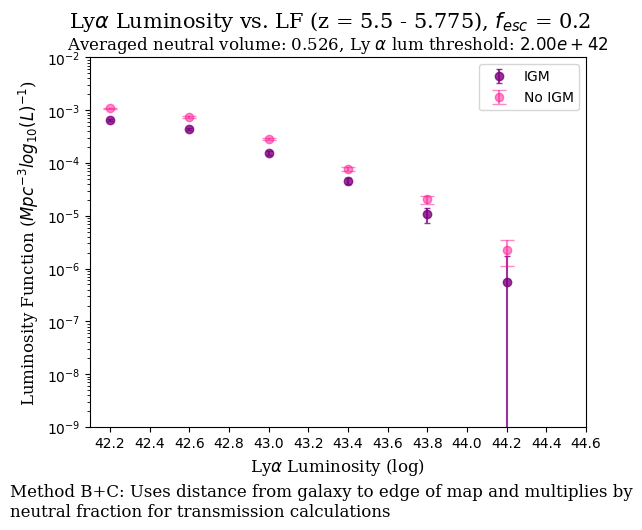

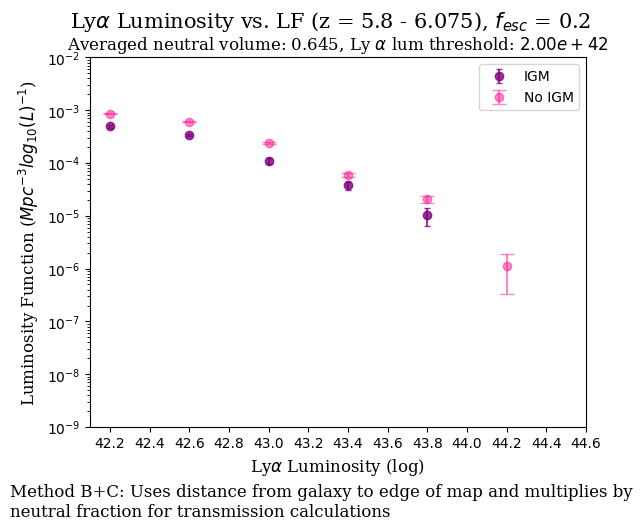

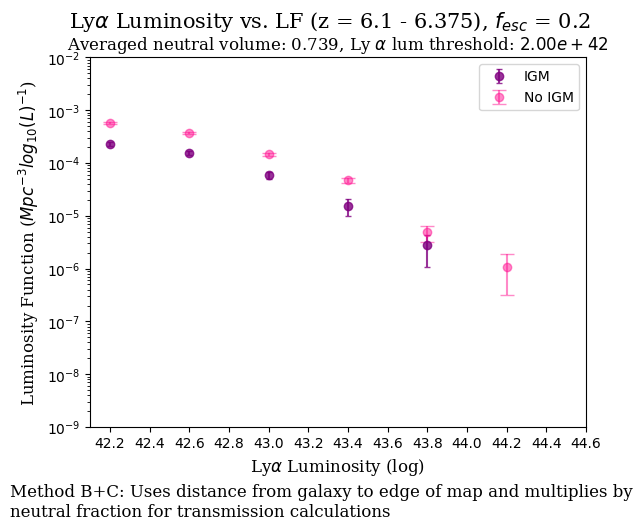

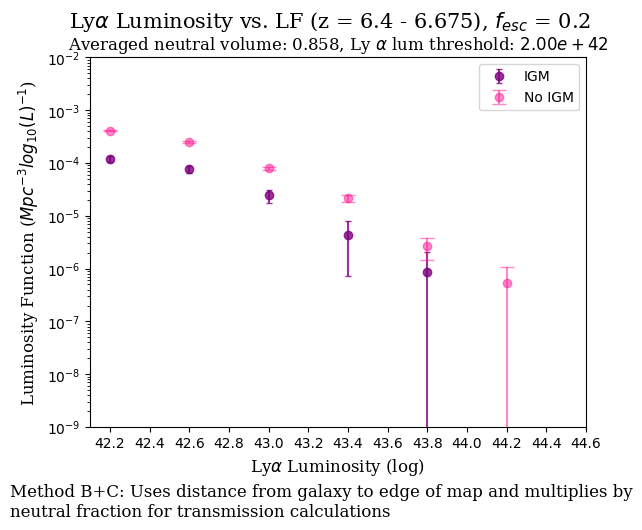

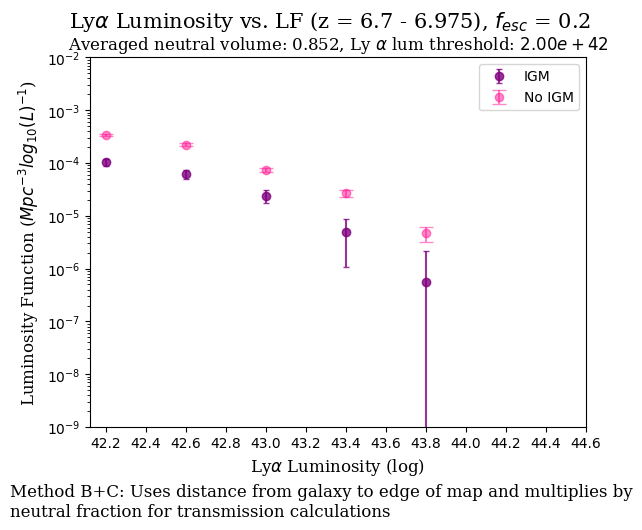

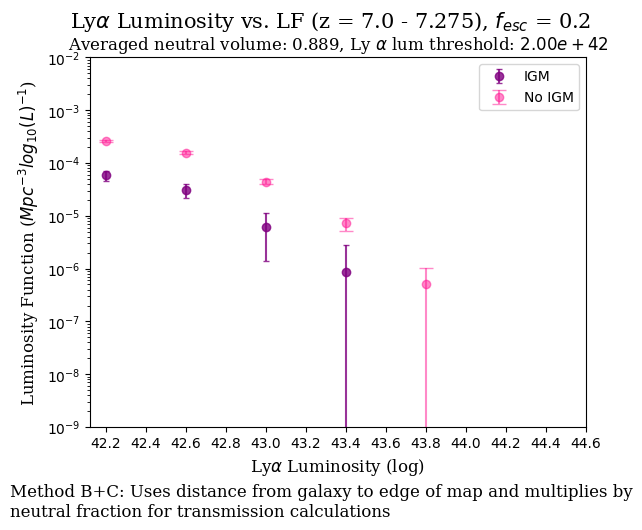

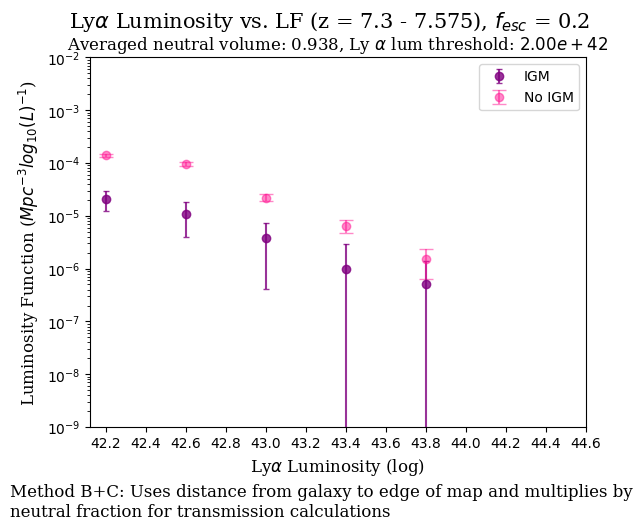

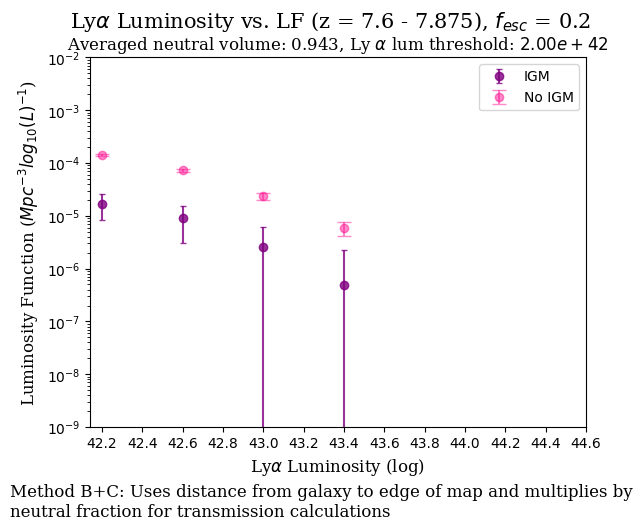

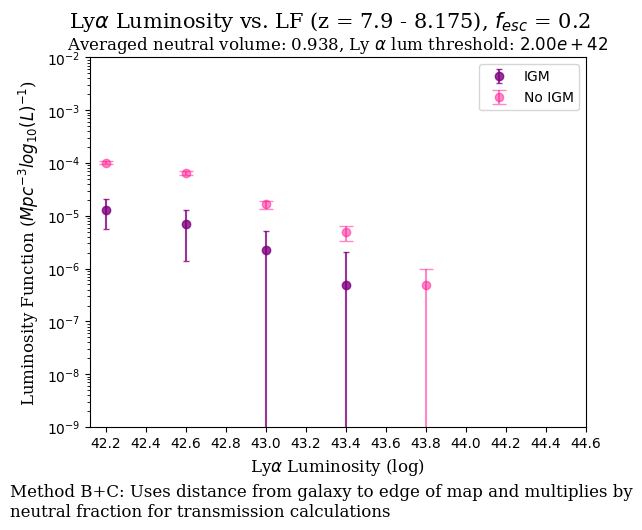

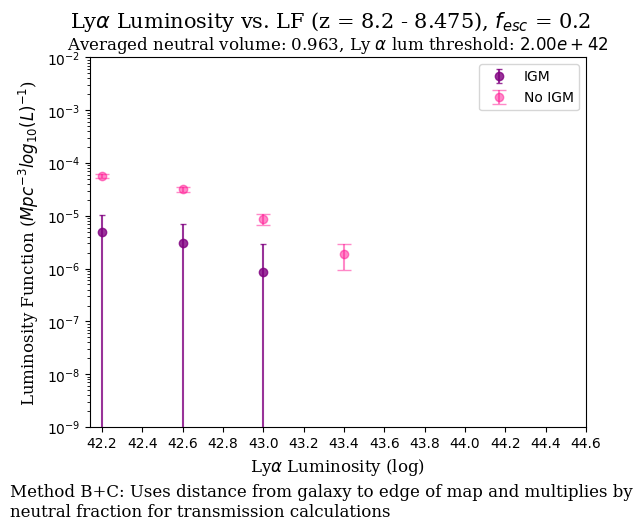

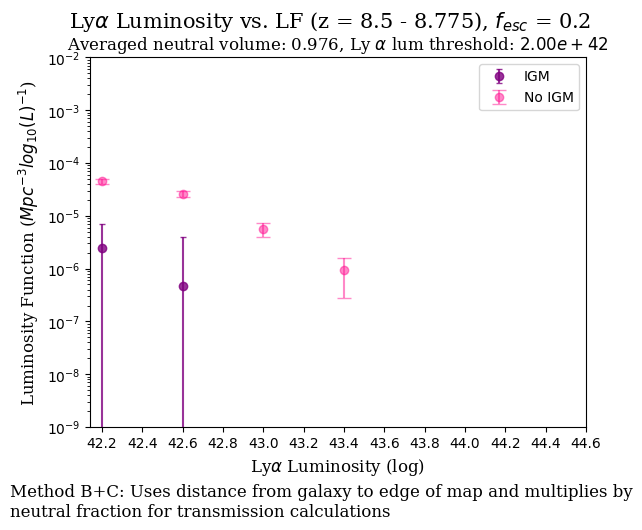

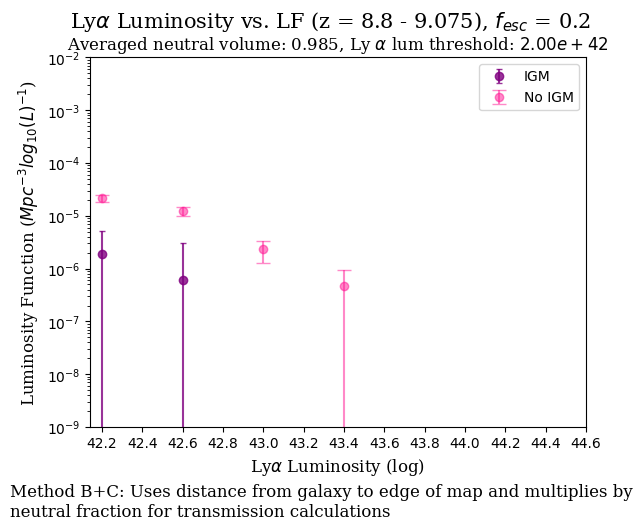

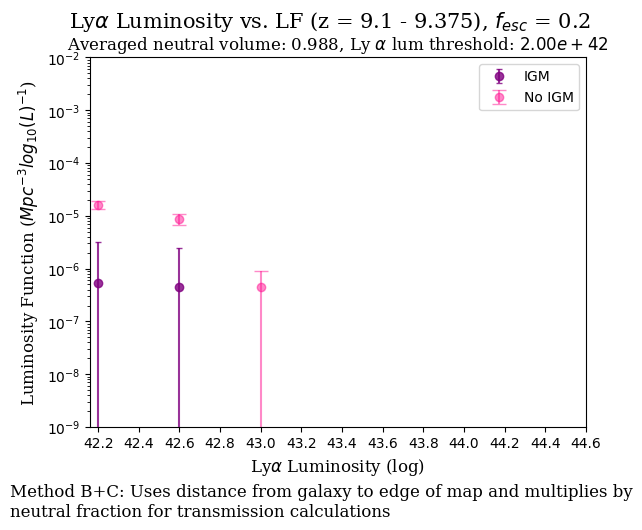

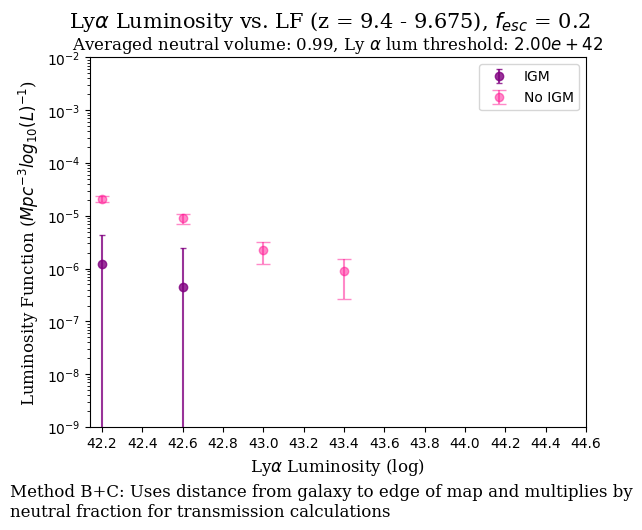

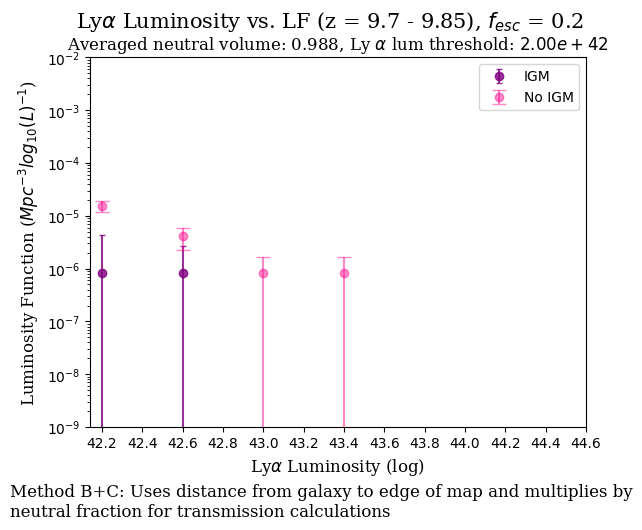

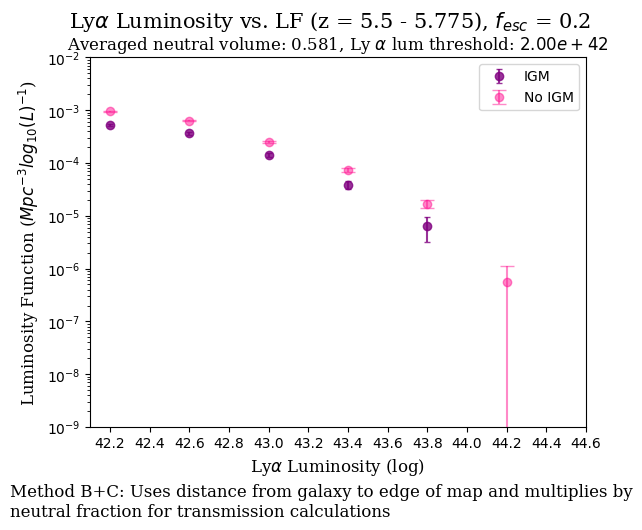

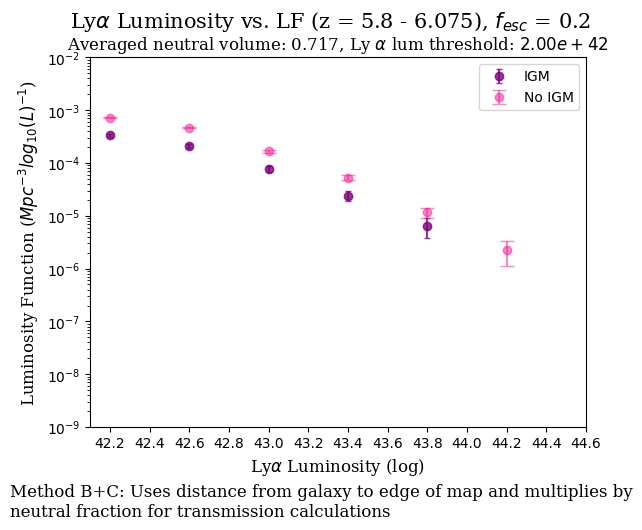

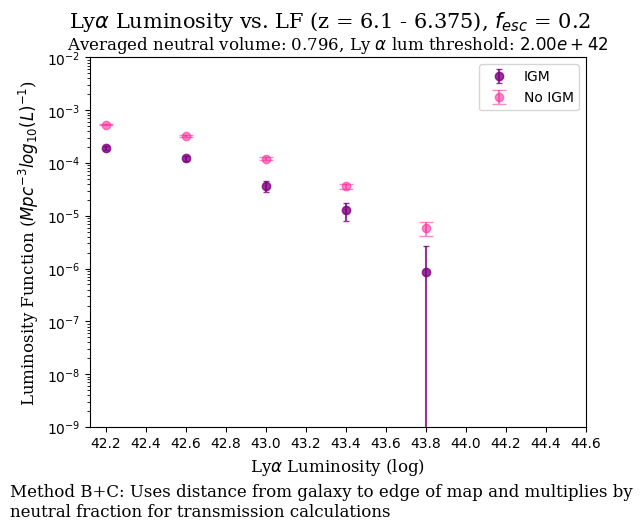

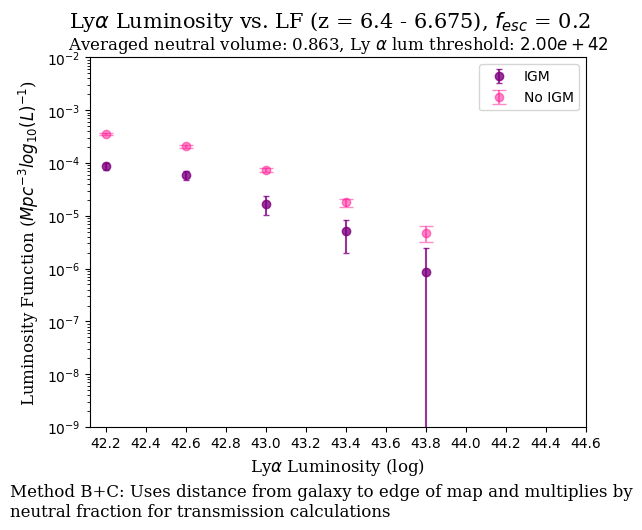

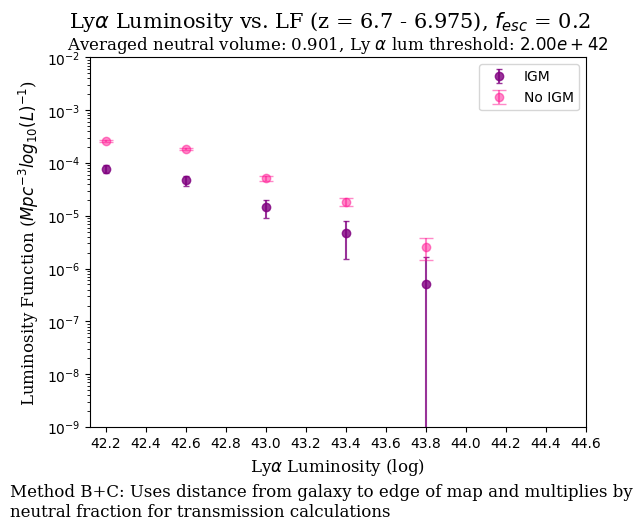

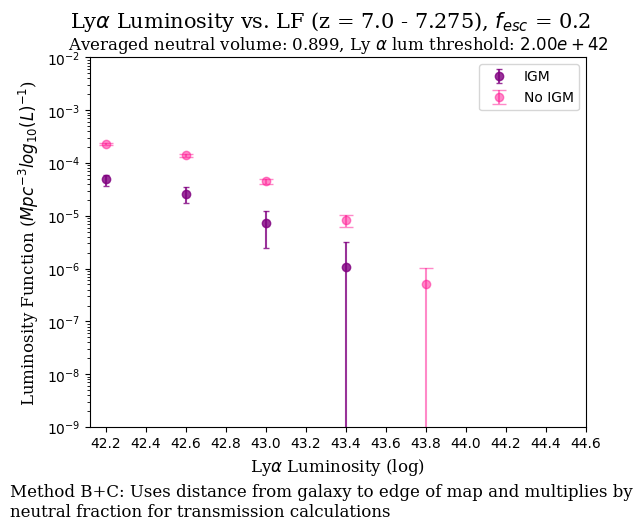

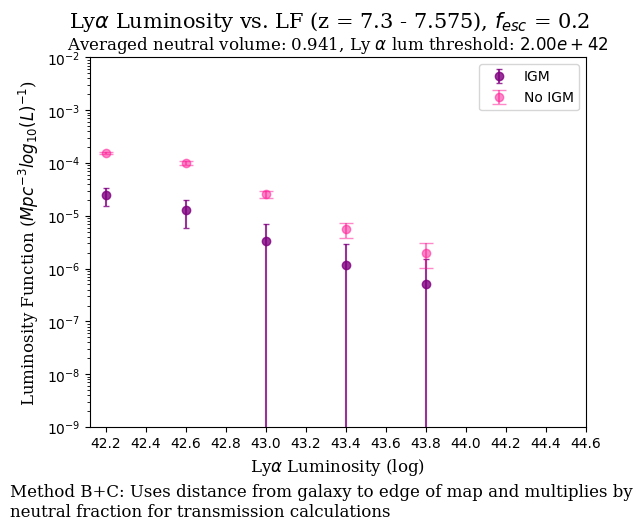

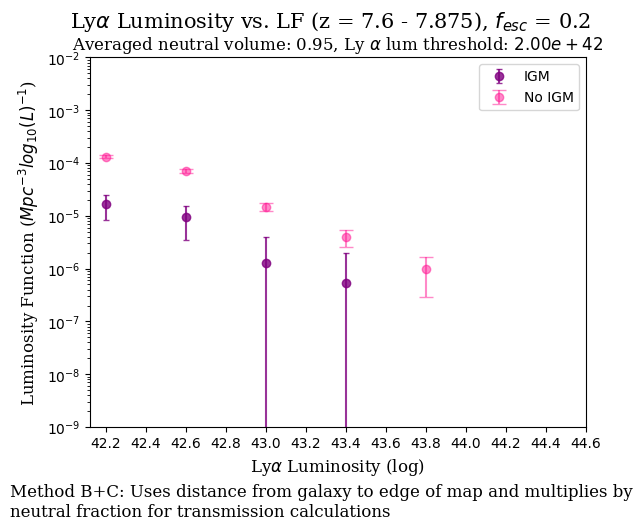

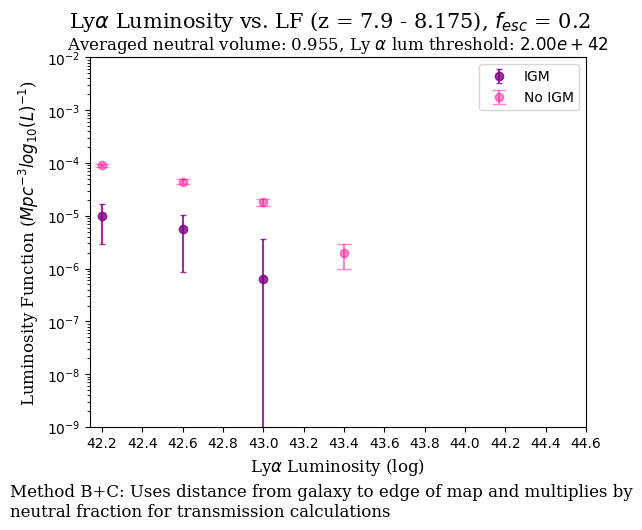

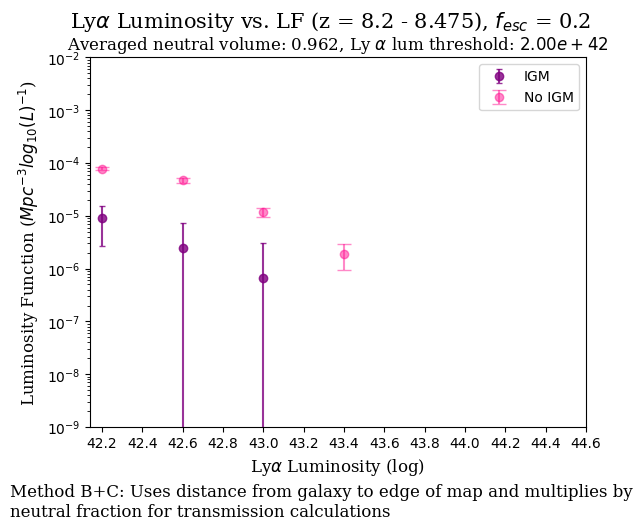

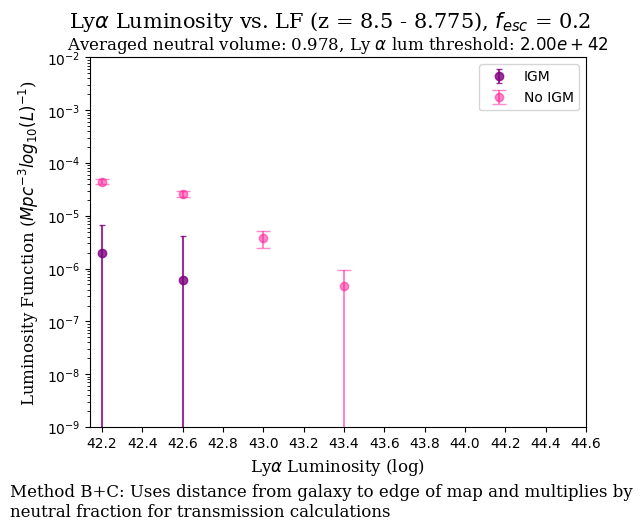

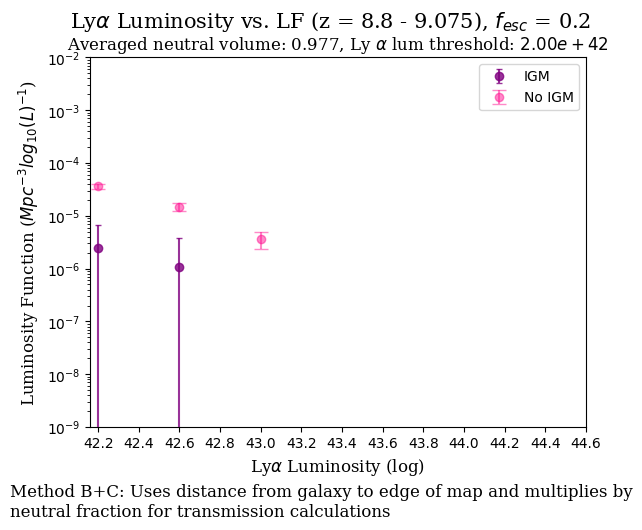

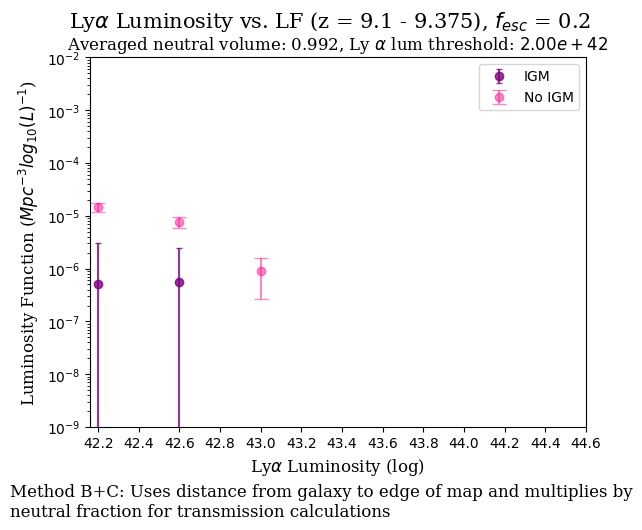

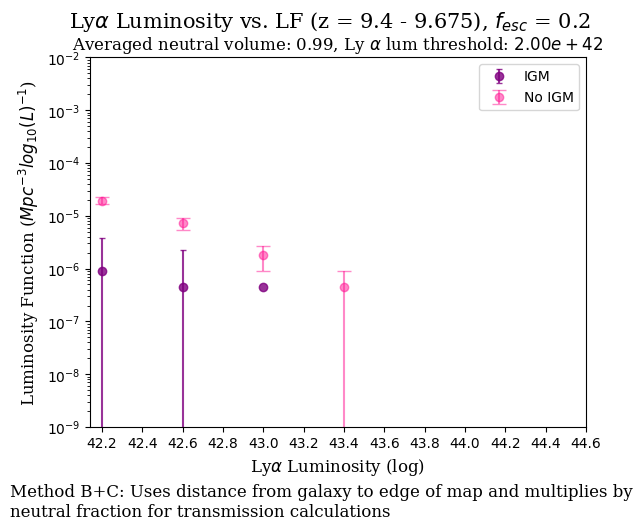

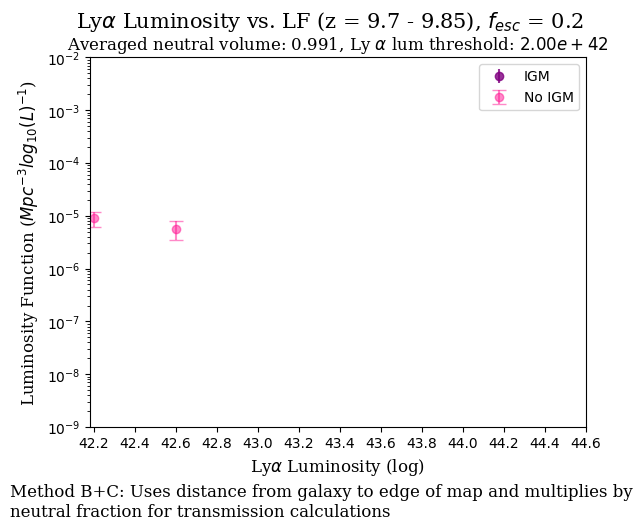

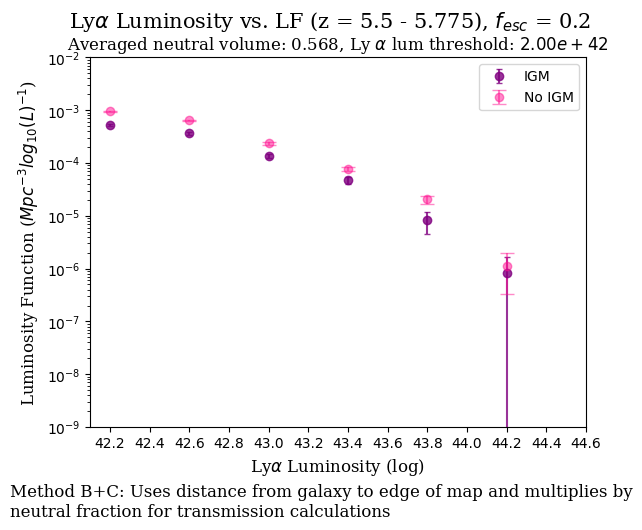

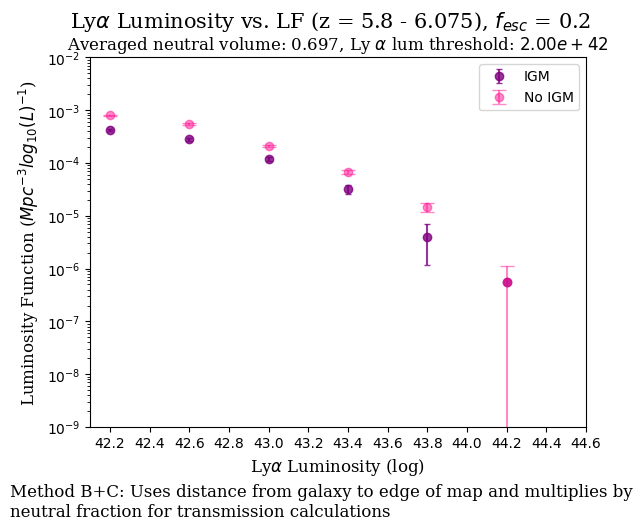

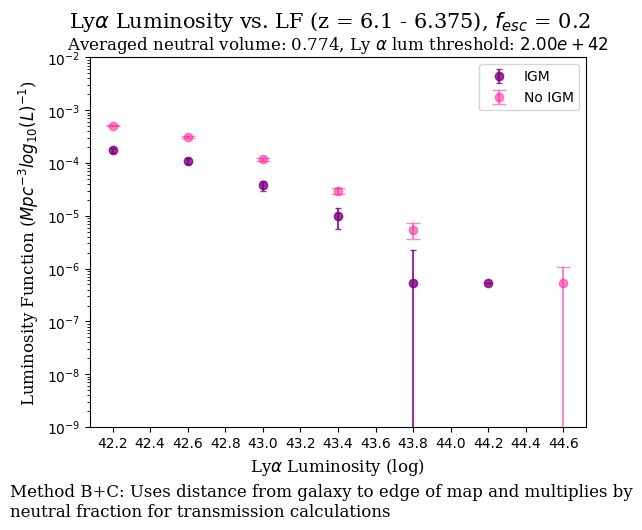

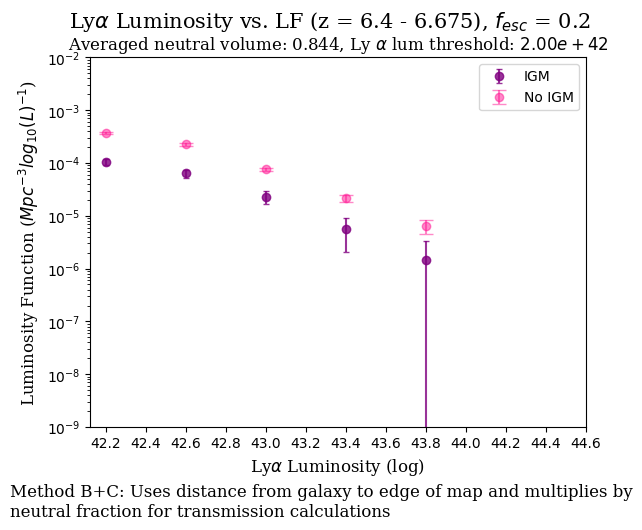

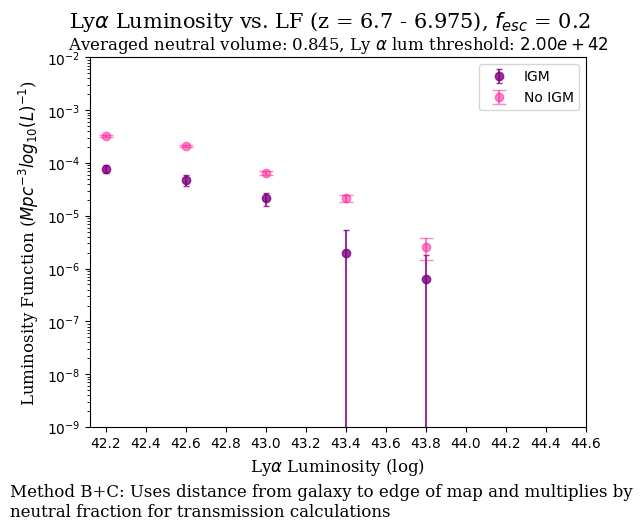

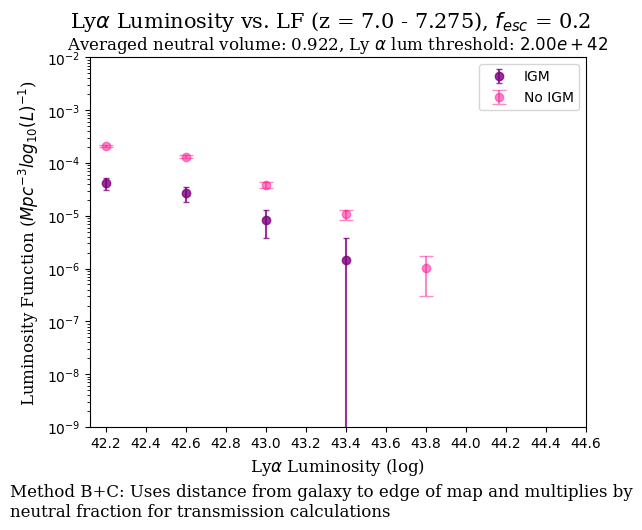

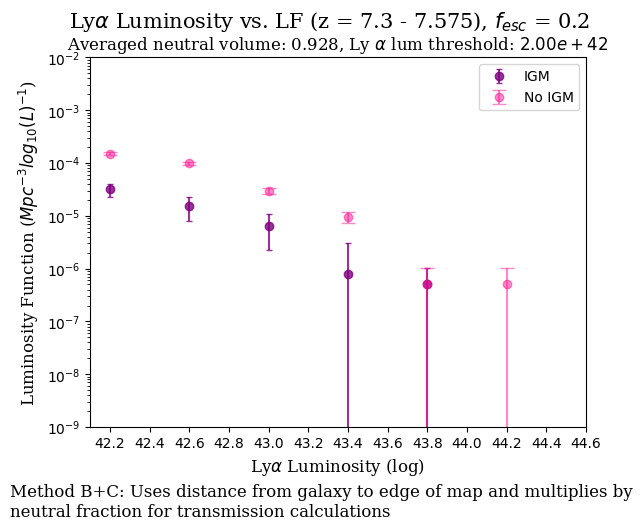

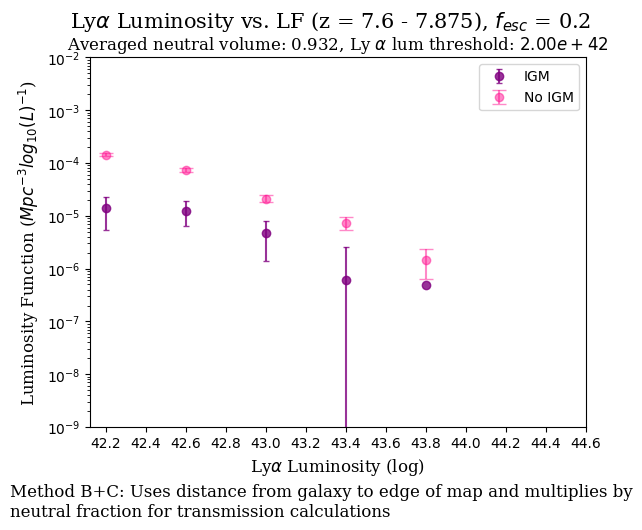

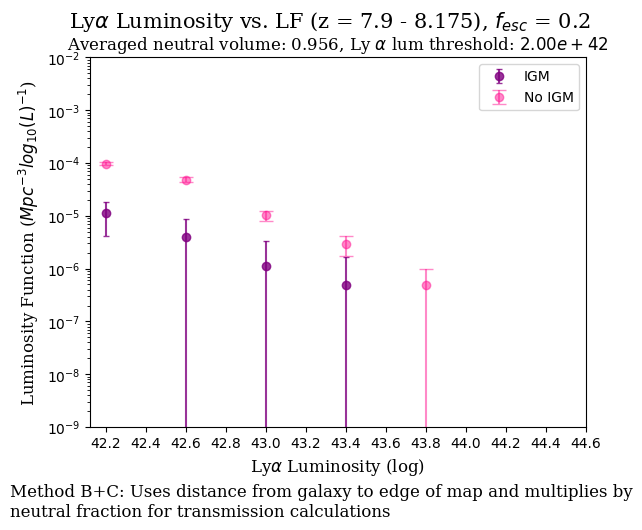

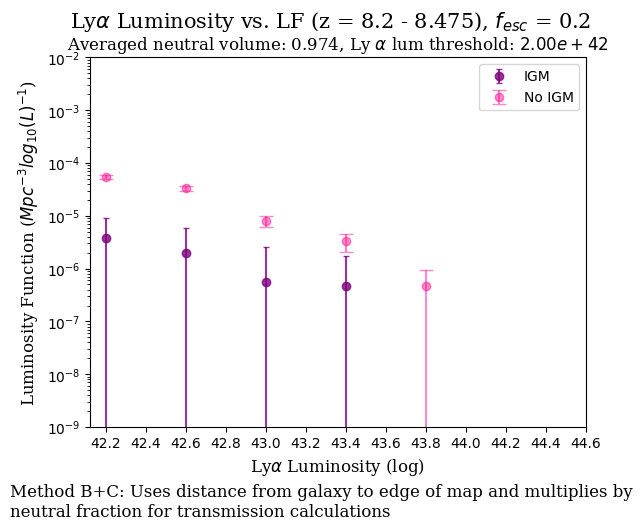

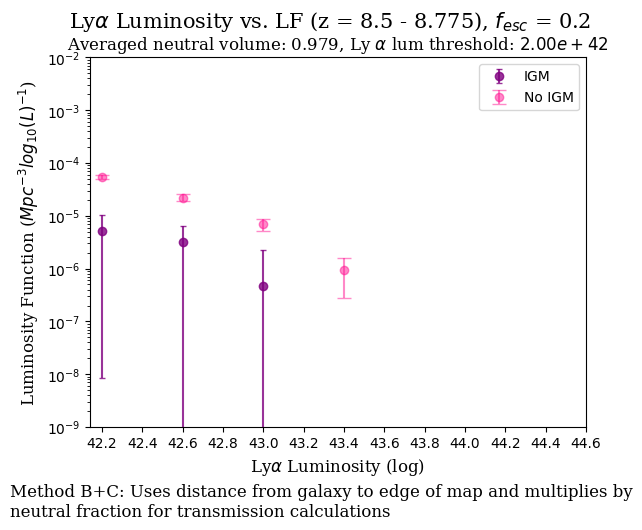

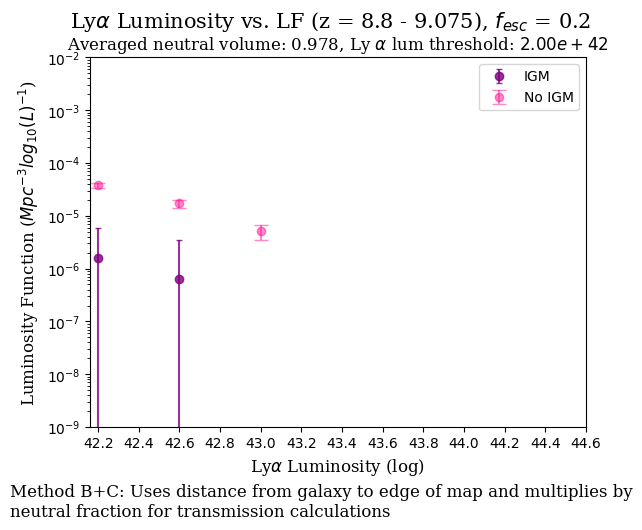

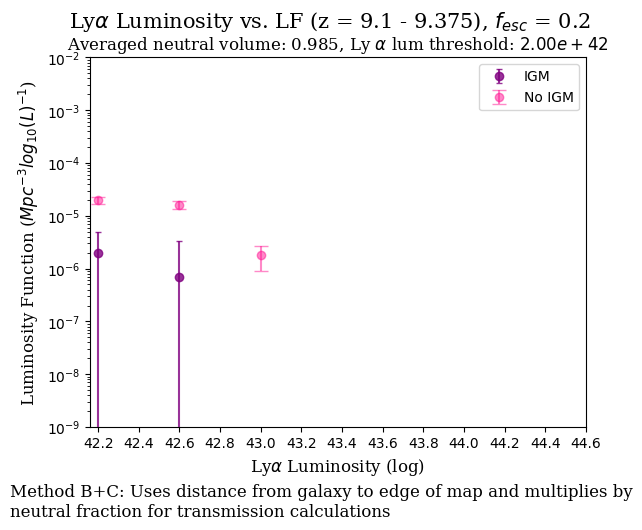

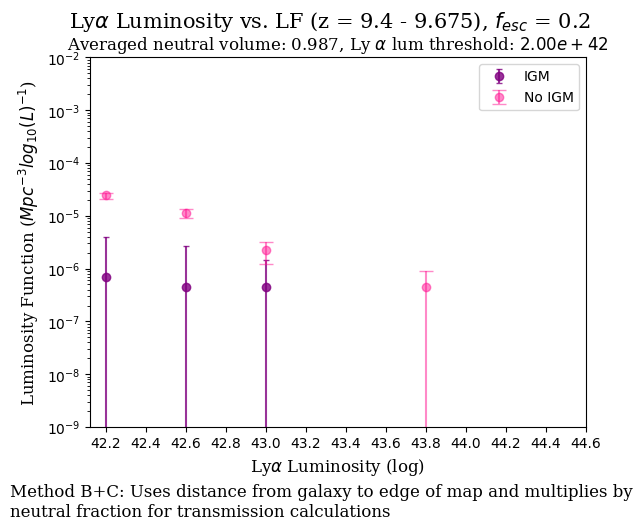

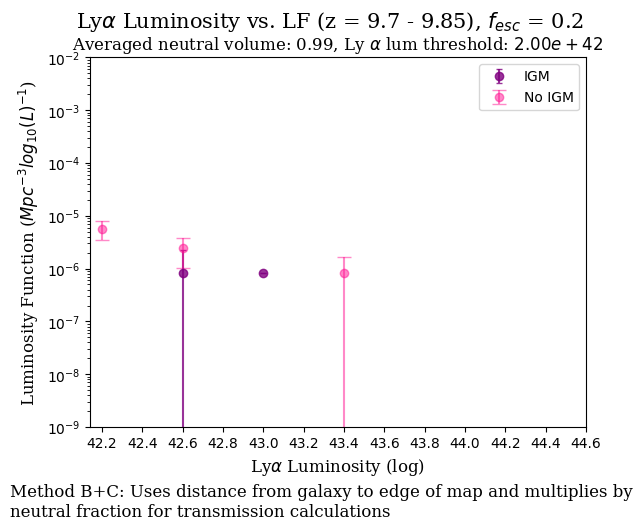

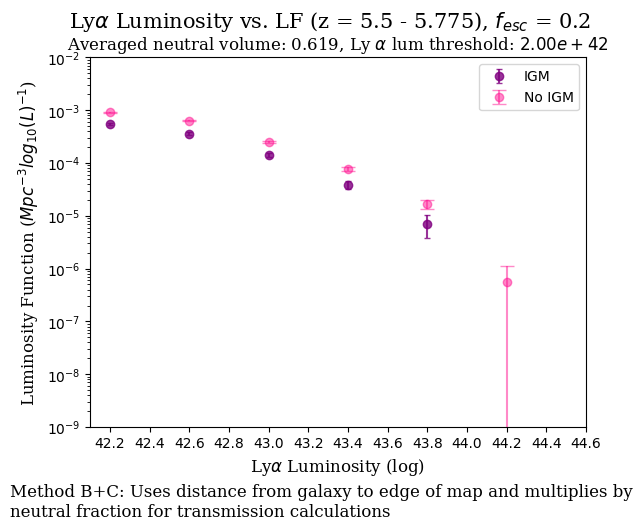

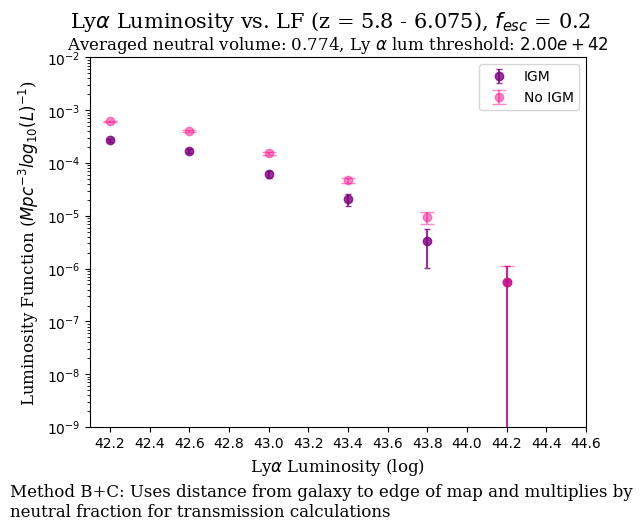

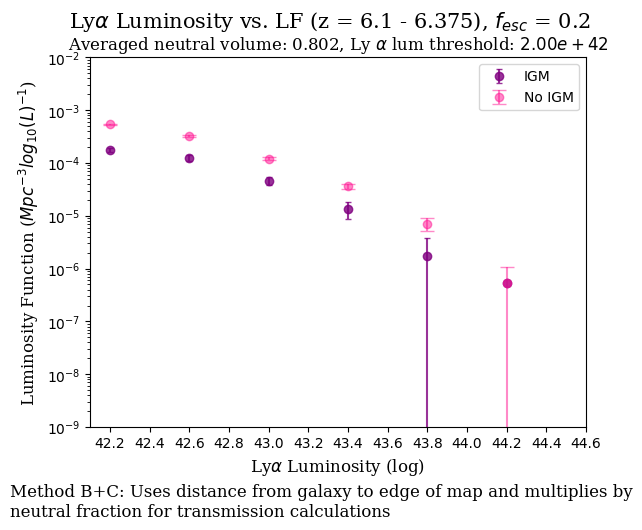

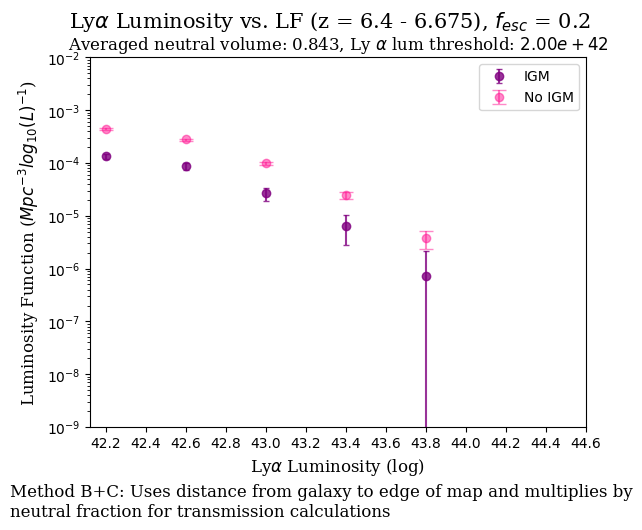

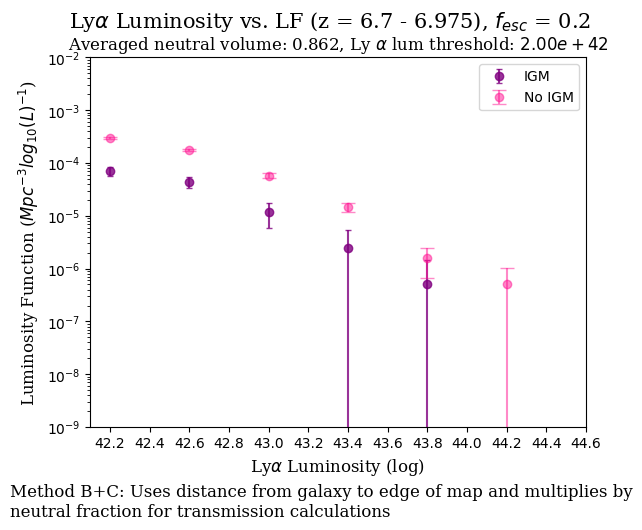

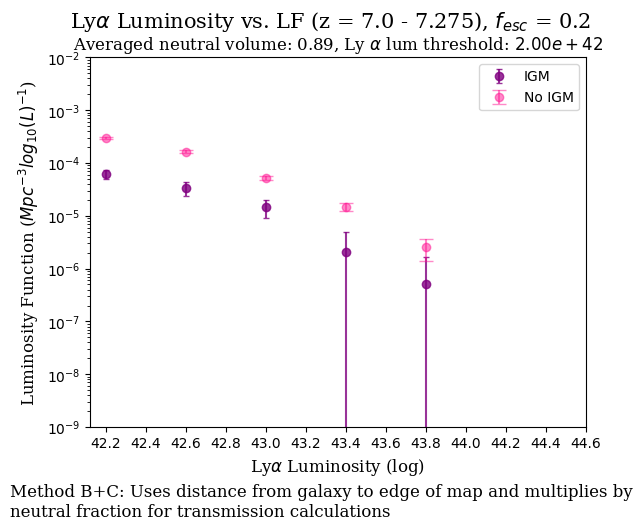

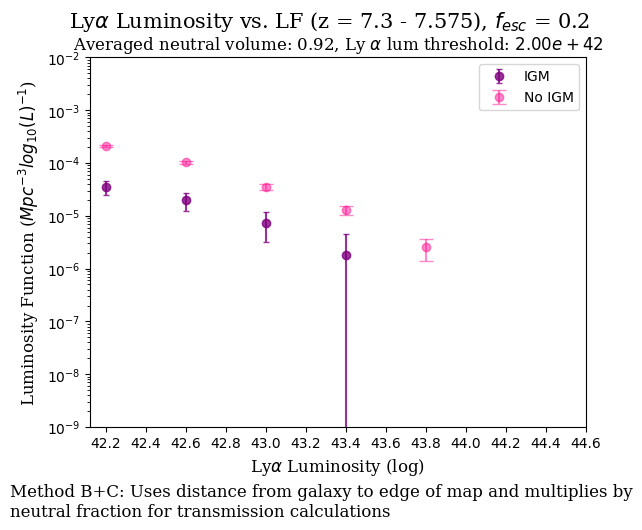

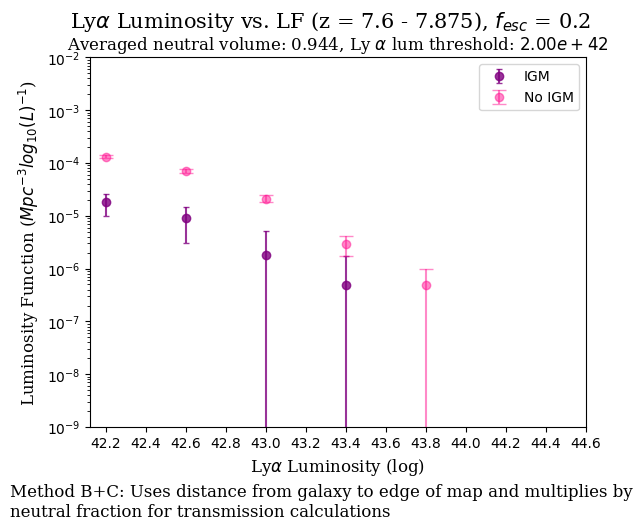

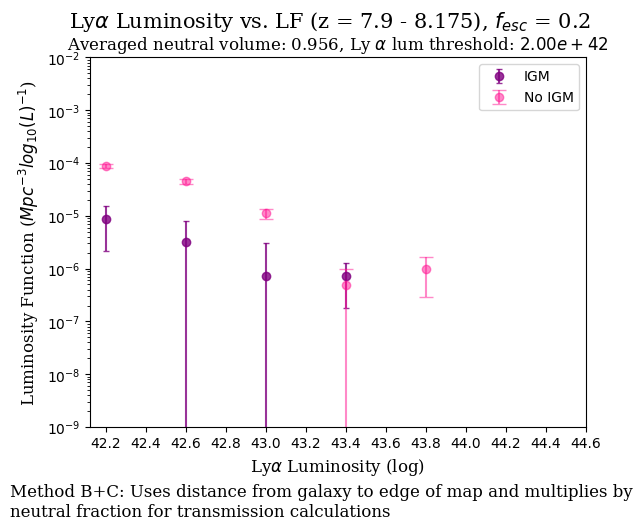

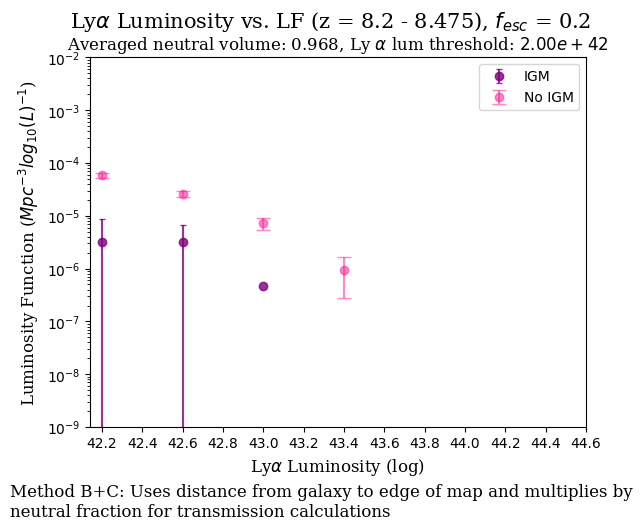

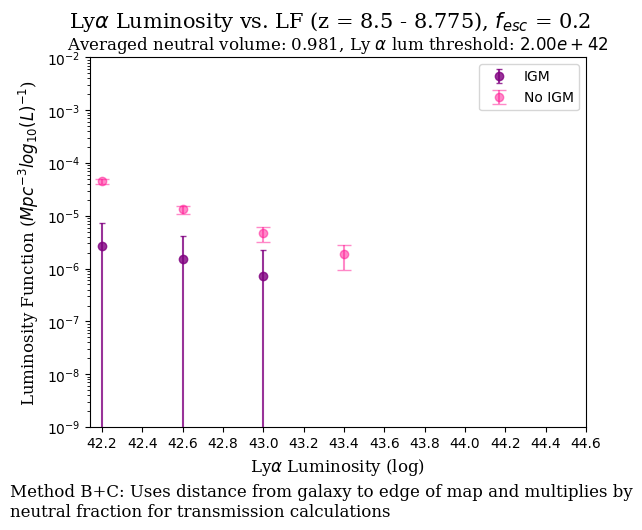

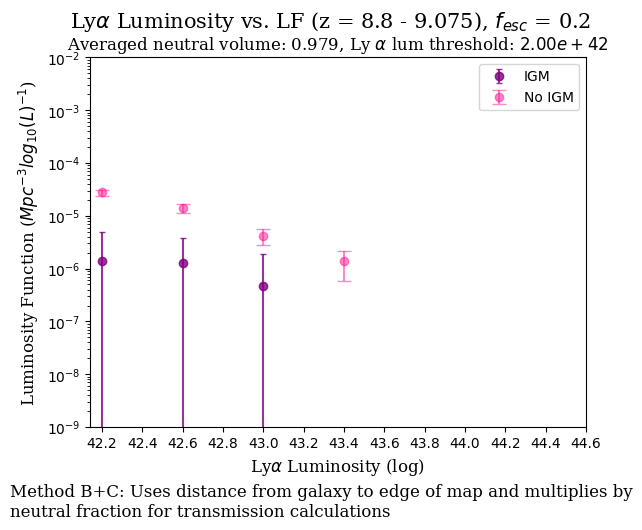

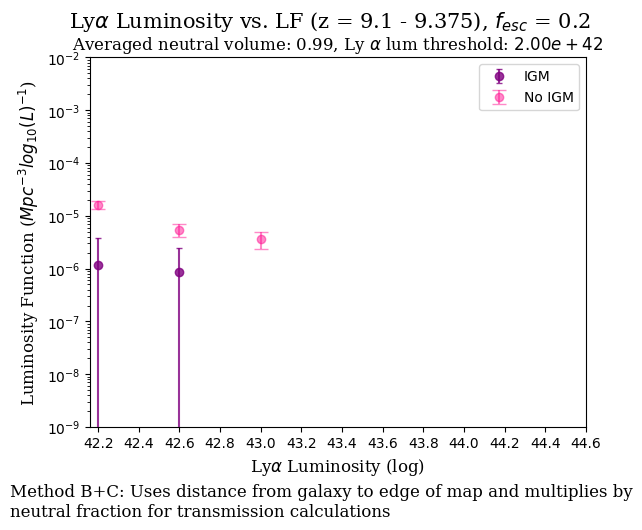

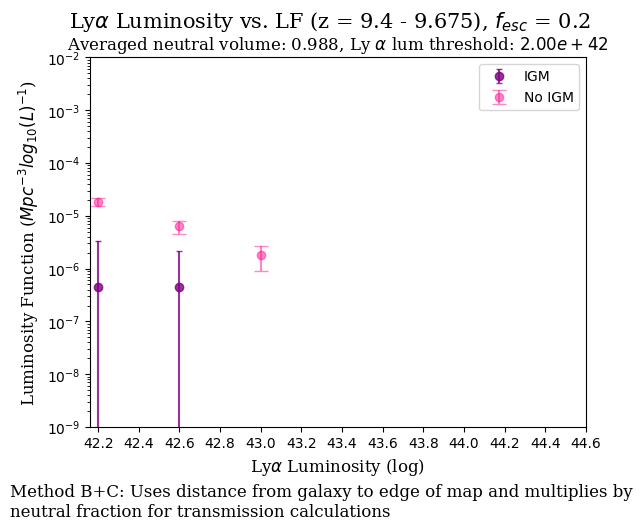

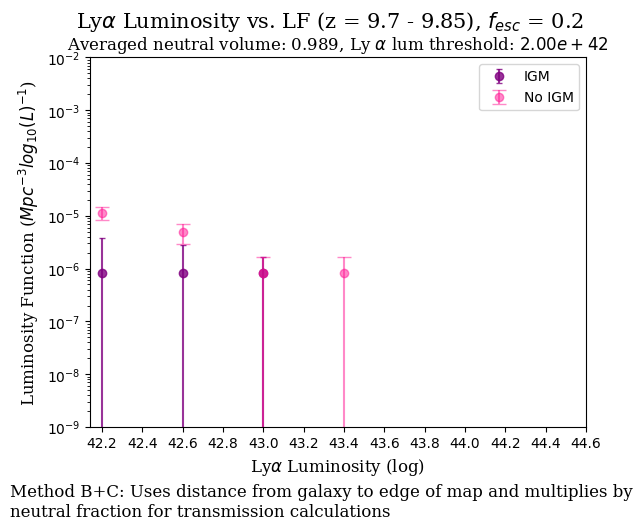

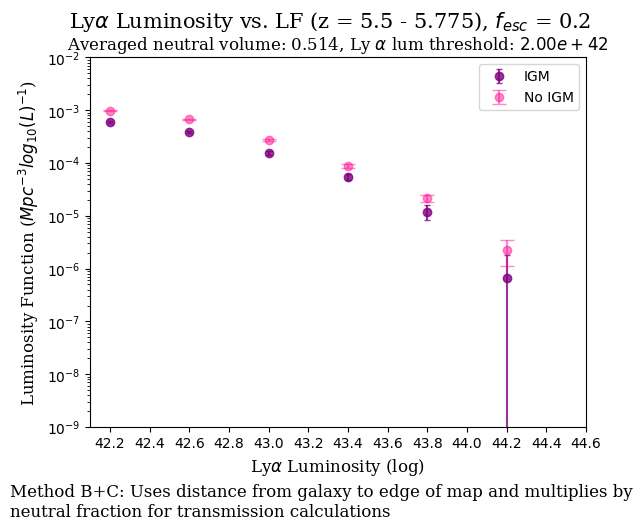

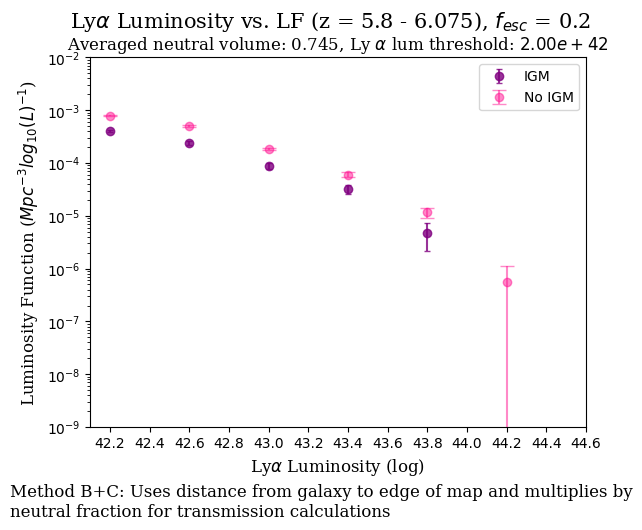

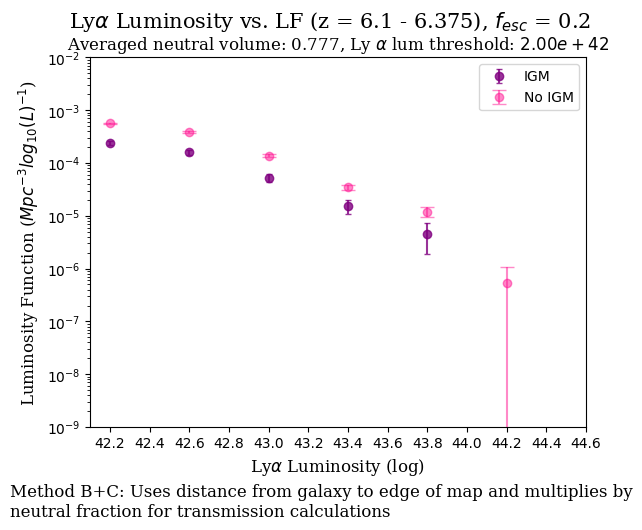

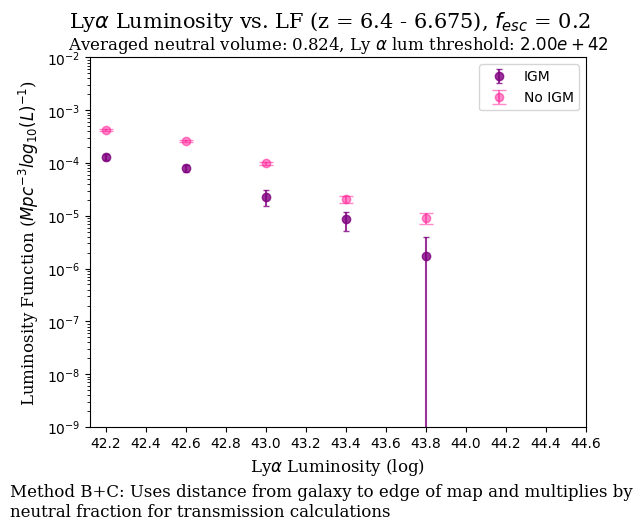

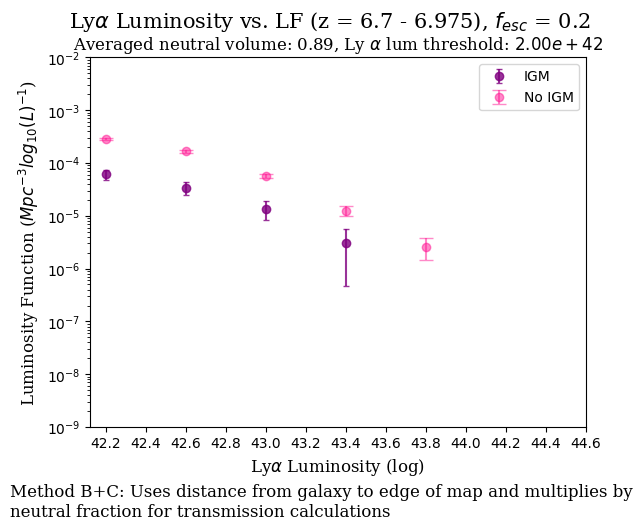

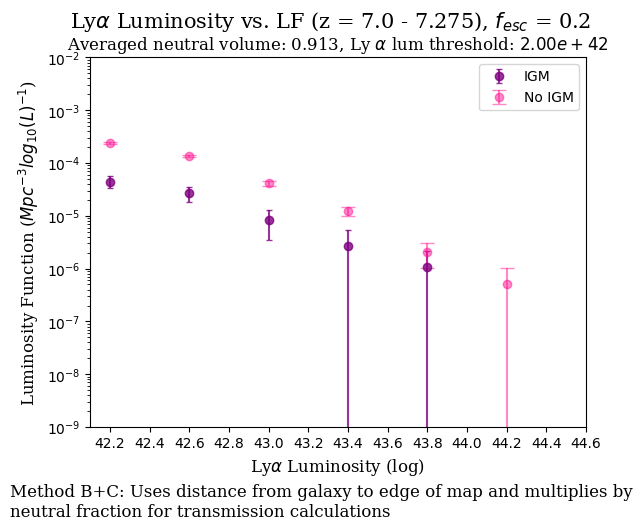

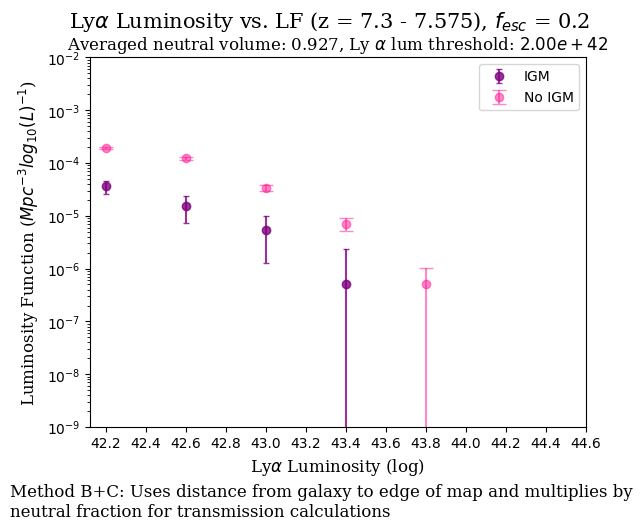

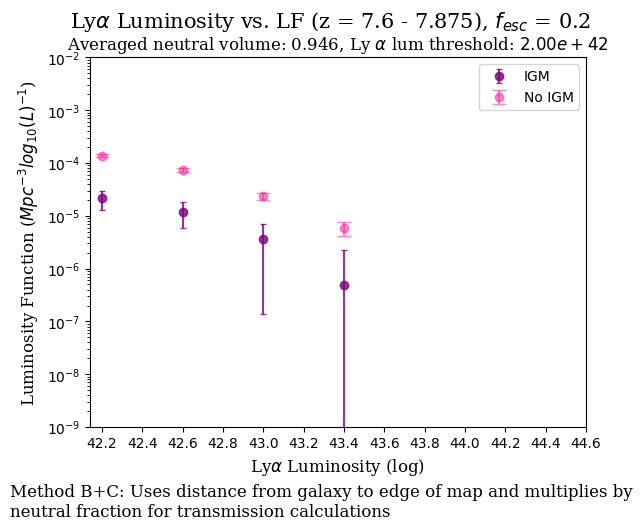

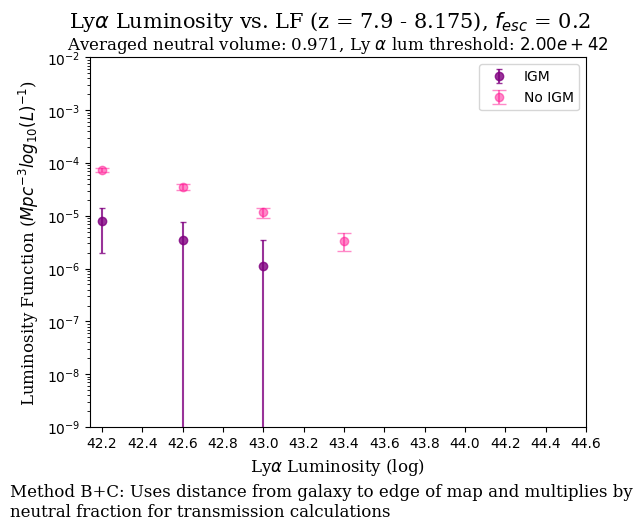

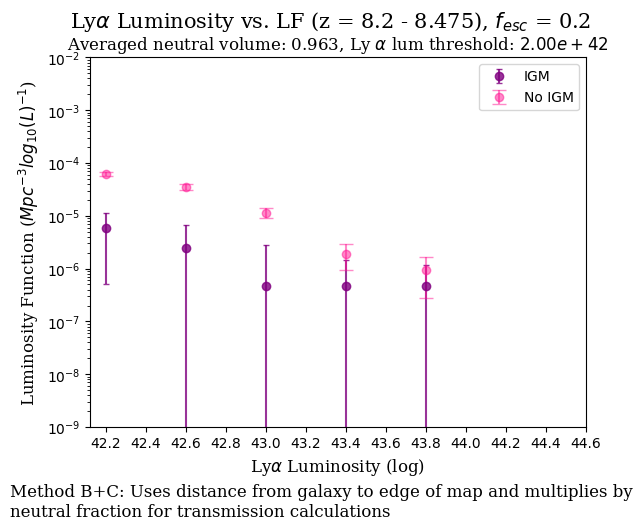

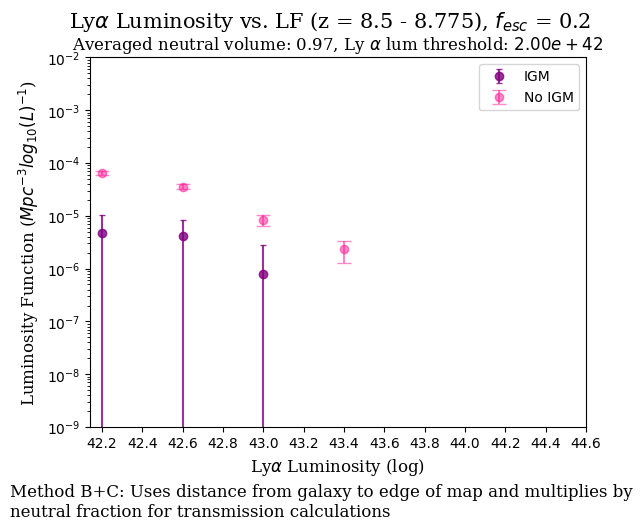

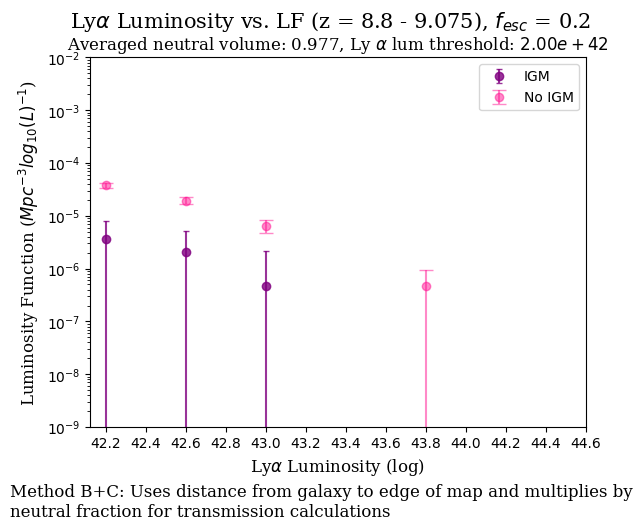

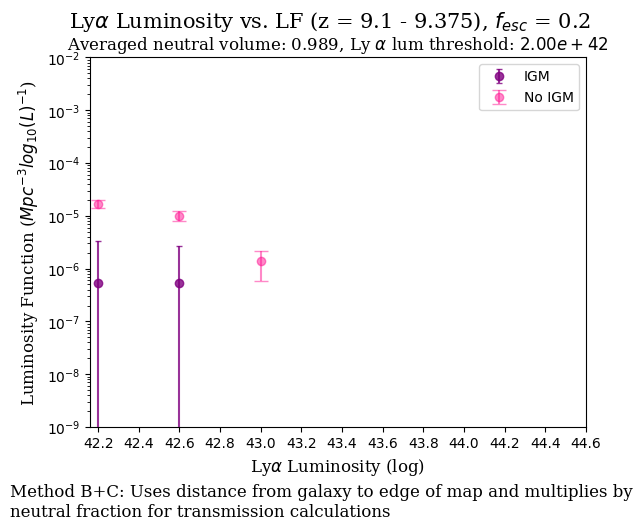

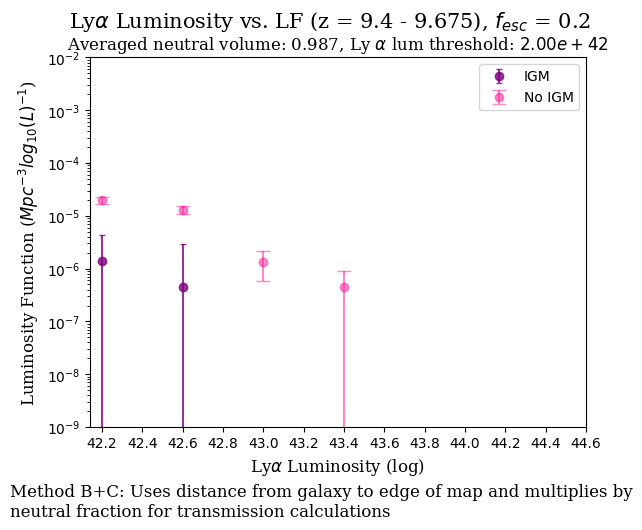

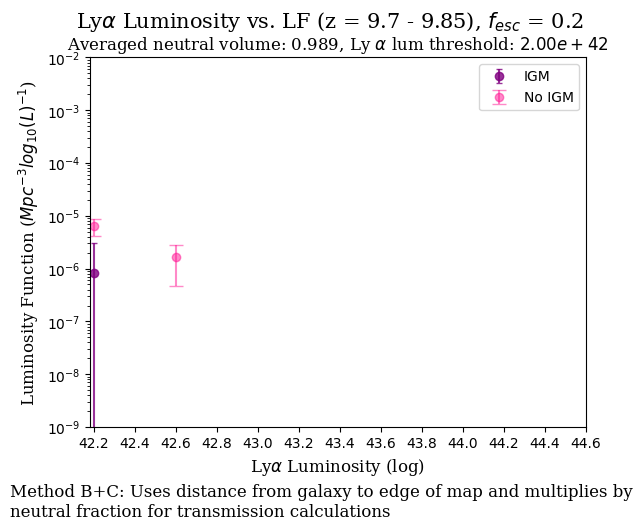

In [74]:
"""Luminosity Function Creation Explanation
This code generates LF for a set of redshifts across a wide redshift range and returns LF figures, LF csv files, and neutral fraction csv
Start by initializing values such as the initial redshift, the index step, the delta z for each redshift bin (z_step), 
and luminosity bins (for neutral fraction csv file creation)
The index step is +1 larger than what the z_step is being multiplied by to avoid double counting 
Reminder: the redshift for each map (which is what is being read) includes +/- 0.0125 from center of redshift
z_step is being multiplied by 0.025 because that is the delta z of each map, thus what 0.025 is being multiplied 
by is the number of maps to be read
In the for loop we are looping through the *number* of maps to read through 
The creation of the LF is for each redshift bin (example, could be 7 - 7.3) and reads through each csv file for that range to create LF
LF csv file also includes errors, pre transmission are poisson errors while post transmission errors are poisson errors + standard deviation
of all angles
create_LF also returns the number of pre IGM and post IGM numbers (post IGM has been normalized) 
"""
initial_z = 5.50
max_z = 9.850
method = 'BC'
wide_list = ['wide.0', 'wide.1', 'wide.2', 'wide.3', 'wide.4']
threshold = 0.2
for realization in wide_list:
    path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/'
    current_z = 5.50
    z_step = 0.025 * 11
    index_step = 12 #index step is the number of indexes corresponding to the maps in the directory to use for LF calculations
    #index step is one more than z step because the index includes index 0, the number of maps to use will always be index_step-1
    
    number_laes_pt = [] 
    number_laes_t = []
    luminosity_bins = np.arange(42.2, 44.7, step = 0.4)
    folder = os.listdir(f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/RadiusDataFesc{threshold}')
    for i in np.arange(1, len(folder), step = index_step): 
        if current_z >= 9.85: 
            break
        if i + index_step > len(folder): 
            index_step = (len(folder)-1)-i
            z_step = 9.85 - current_z
        print(current_z)
        radius_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/RadiusDataFesc{threshold}' #where threshold = 1.1 lives 
        pre_trans_lae, trans_lae, no_laes_pt, no_laes_t = create_LF(current_z, current_z+z_step, i, i+index_step,\
                                                                    radius_path = radius_path, bin_step = 0.4, \
                                                                    min_bin = 42.2, max_bin = 44.8, downloadPath = path,\
                                             threshold = threshold, printing = False, luminosity_threshold = 2*10**42, \
                                                                    method = method, realization = realization)
        number_laes_pt.append(no_laes_pt)
        number_laes_t.append(no_laes_t)
        savefig_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/LF_imagesFesc{threshold}/'
        hdf5path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/pklFiles'
        figure = lf_fig(trans_lae, pre_trans_lae, np.round(current_z, 2), z_step, threshold = threshold, min_bin = 42.2, \
                        max_bin = 44.8, lum_threshold = 2*10**42, method = method, realization = realization, \
                        figsavepath = savefig_path, hdf5path = hdf5path)
        current_z = np.round(current_z + z_step+0.025, 2)
        
    neutral_frac_df = create_neutral_frac_df(min_z = 5.50, max_z = max_z, threshold = threshold, \
                                             no_laes_pt= number_laes_pt, no_laes_t = number_laes_t, \
                                             z_step = 11*0.025, luminosity_bins = luminosity_bins, \
                                             realization = realization, hdf5path = hdf5path)
    download_frac_path = f'/Users/slkumar/Downloads/CorrectionFactorMaps/{realization}/NeutralFraction/'
    neutral_frac_df.to_csv(download_frac_path + f'NeutralFractions{threshold}.csv')